# Textile Waste predictions based on Economic Indicators

### by Kristin Scully

------------------------

Can we predict how much textile waste will be generated in the future based on economic factors?

## Data

From fred.stlouis.gov:
- US GDP from 1950 to Q3 2023 
- Consumer Price Index of clothing and footwear for all US not seasonally adjusted from 2012 to 2023
- Personal consumption expenditures of clothing, footwear, and related services from 1929 to 2022
- Inflation of consumer prices for the United States from 1960 to 2022
- US Recession data from 1854-2023

& Municipal solid textile waste including data from 1960 – 2018

# Methodology

Since we have Municipal Solid Waste data from 1960 to 2018, we will use the  economic indicators to predict the waste generation from 2019-2022

In [126]:
# import libraries
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import ensemble

from scipy import stats
from scipy.stats import f_oneway


In [127]:
# Clean Data

Directory = 'C:/Users/billy/Documents/Homework/Data Practicum/Project/DataPracticum1/'

# Quarterly
fileGDP = pd.read_csv(Directory + 'Inputs/GDP.csv', names=['Date', 'GDP'], header=0)

# Monthly
fileRecession = pd.read_csv(Directory + 'Inputs/USREC.csv', names=['Date','Rec'], header=0)
fileCPI = pd.read_csv(Directory + 'Inputs/CPI.csv', 
                      names=['Date', 'CPI'], header=0)

#Yearly
filePCE = pd.read_csv(Directory + 'Inputs/PCE.csv',
                                              names=['Date', 'PCE'],
                                              header=0)

fileInflation = pd.read_csv(Directory + 'Inputs/Inflation.csv',
                            names=['Date', 'Inflation'], header=0)

fileWasteGenerated = pd.read_excel(Directory + 'Inputs/Materials_Municipal_Waste_Stream_1960_2018.xlsx',
                                   sheet_name='Materials generated', index_col=0)

print("GDP Dates: ", fileGDP.Date.min())
print("CPI Dates: ", fileCPI.Date.min())
print("PCE Dates: ", filePCE.Date.min())
print("Inflation Dates: ", fileInflation.Date.min())

GDP Dates:  1947-01-01
CPI Dates:  2011-12-01
PCE Dates:  1929-01-01
Inflation Dates:  1960-01-01


In [128]:
''' Since the data is characterized by different date ranges
I will extrapolate the months and fill in the missing data 
two ways: forward filling and using machine learning. '''

filePCE.Date = pd.to_datetime(filePCE.Date, errors='coerce')
filePCE = filePCE.set_index('Date').resample('M').ffill().reset_index()
fileInflation.Date = pd.to_datetime(fileInflation.Date, errors='coerce')
fileInflation = fileInflation.set_index('Date').resample('M').ffill().reset_index()
fileGDP.Date = pd.to_datetime(fileGDP.Date, errors='coerce')
fileGDP = fileGDP.set_index('Date').resample('M').ffill().reset_index()

fileWasteGenerated = fileWasteGenerated.T
fileWasteGenerated = fileWasteGenerated[['Products - Textiles']].copy()
fileWasteGenerated.reset_index(inplace=True)
fileWasteGenerated.rename(columns={'index':'Date',
                                   'Products - Textiles':'WasteGenerated'},
                          inplace=True)
# =============================================================================
fileWasteGenerated.Date = pd.to_datetime(fileWasteGenerated.Date, format='%Y')
fileWasteGenerated = fileWasteGenerated.set_index('Date').resample('M').ffill().reset_index()

fileRecession.Date = pd.to_datetime(fileRecession.Date, errors='coerce')
fileRecession = fileRecession.set_index('Date').resample('M').ffill().reset_index()

fileCPI.Date = pd.to_datetime(fileCPI.Date, errors='coerce')
fileCPI = fileCPI.set_index('Date').resample('M').ffill().reset_index()


df = fileRecession.merge(
    fileGDP, how='left').merge(
    fileInflation, how='left').merge(
    filePCE, how='left').merge(
    fileCPI, how='left').merge(
    fileWasteGenerated, how='left')


In [129]:
df.describe()

,Rec,GDP,Inflation,PCE,CPI,WasteGenerated
count,2029.000000,919.000000,745.000000,1117.000000,145.000000,6.970000e+02
mean,0.285362,7046.990295,3.702266,144.711025,0.022068,6.009799e+06
std,0.451698,7245.648275,2.735816,142.241315,0.083007,4.850730e+06
min,0.000000,243.164000,-0.355546,5.062000,-0.216779,1.760000e+06
25%,0.000000,795.734000,1.812210,23.940000,-0.023380,2.040000e+06
50%,0.000000,4294.887000,3.015075,71.433000,0.013516,2.530000e+06
75%,1.000000,12112.815000,4.300535,273.082000,0.073988,9.480000e+06
max,1.000000,27610.128000,13.549202,518.323000,0.201492,1.703000e+07


There are too many missing values for CPI. Let's drop CPI.

In [130]:
df.drop(columns='CPI', inplace=True)

In [131]:
'''Since we have Municipal Solid Waste data from 1960 to 2018, 
we will use the economic indicators to predict the 
waste generation from 2019-2022. We will train and test the data
from 1960 to 2018'''

# Forward Filled

full_ff = df[(df['Date'] >= '1960-01-31') & (df['Date'] <= '2022-01-31')].copy().reset_index(drop=True)
train_test_ff = df[(df['Date'] >= '1960-01-31') & (df['Date'] <= '2018-01-31')].copy().reset_index(drop=True)
validate_ff = df[(df['Date'] >= '2019-01-31')].copy().reset_index(drop=True)

print(full_ff.columns)

full_ff.to_csv(Directory + 'Output/Full Forward Filled data set.csv', index=False)
train_test_ff.to_csv(Directory + 'Output/Train_Test Forward Filled data set.csv', index=False)
validate_ff.to_csv(Directory + 'Output/validation Forward Filled data set.csv', index=False)

Index(['Date', 'Rec', 'GDP', 'Inflation', 'PCE', 'WasteGenerated'], dtype='object')


In [132]:
full_ff.corr().to_csv(Directory + 'Output/FFill Correlation Matrix.csv')
full_ff.corr()

C:\Users\billy\AppData\Local\Temp\ipykernel_22948\1469667163.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  full_ff.corr().to_csv(Directory + 'Output/FFill Correlation Matrix.csv')
C:\Users\billy\AppData\Local\Temp\ipykernel_22948\1469667163.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  full_ff.corr()


,Rec,GDP,Inflation,PCE,WasteGenerated
Rec,1.000000,-0.123751,0.296884,-0.139956,-0.087978
GDP,-0.123751,1.000000,-0.403605,0.975588,0.980708
Inflation,0.296884,-0.403605,1.000000,-0.389517,-0.437309
PCE,-0.139956,0.975588,-0.389517,1.000000,0.932674
WasteGenerated,-0.087978,0.980708,-0.437309,0.932674,1.000000


In [133]:
# Machine Learning Fill

Directory = 'C:/Users/billy/Documents/Homework/Data Practicum/Project/DataPracticum1/'

# Quarterly
fileGDP = pd.read_csv(Directory + 'Inputs/GDP.csv', names=['Date', 'GDP'], header=0)

# Monthly
fileRecession = pd.read_csv(Directory + 'Inputs/USREC.csv', names=['Date','Rec'], header=0)

#Yearly
filePCE = pd.read_csv(Directory + 'Inputs/PCE.csv',
                                              names=['Date', 'PCE'],
                                              header=0)

fileInflation = pd.read_csv(Directory + 'Inputs/Inflation.csv',
                            names=['Date', 'Inflation'], header=0)

fileWasteGenerated = pd.read_excel(Directory + 'Inputs/Materials_Municipal_Waste_Stream_1960_2018.xlsx',
                                   sheet_name='Materials generated', index_col=0)

filePCE.Date = pd.to_datetime(filePCE.Date, errors='coerce')
fileInflation.Date = pd.to_datetime(fileInflation.Date, errors='coerce')
fileGDP.Date = pd.to_datetime(fileGDP.Date, errors='coerce')

fileWasteGenerated = fileWasteGenerated.T
fileWasteGenerated = fileWasteGenerated[['Products - Textiles']].copy()
fileWasteGenerated.reset_index(inplace=True)
fileWasteGenerated.rename(columns={'index':'Date',
                                   'Products - Textiles':'WasteGenerated'},
                          inplace=True)
fileWasteGenerated.Date = pd.to_datetime(fileWasteGenerated.Date)

fileRecession.Date = pd.to_datetime(fileRecession.Date, errors='coerce')

fileCPI.Date = pd.to_datetime(fileCPI.Date, errors='coerce')


df = fileRecession.merge(
    fileGDP, how='left').merge(
    fileInflation, how='left').merge(
    filePCE, how='left').merge(
    fileWasteGenerated, how='left')

full_ml = df[(df['Date'] >= '1960-01-01') & (df['Date'] <= '2022-01-31')].copy().reset_index(drop=True)
train_ml = df[(df['Date'] >= '1960-01-01') & 
                   (df['Date'] <= '2018-01-31') & 
                   (df['WasteGenerated'].isna() == False)].copy().reset_index(drop=True)
fill_ml = df[(df['Date'] >= '1960-01-31') & 
                   (df['Date'] <= '2018-01-31') & 
                   (df['WasteGenerated'].isna() == True)].copy().reset_index(drop=True)
fill_ml.dropna(subset=['GDP', 'Inflation', 'PCE'], inplace=True)
validate_ml = df[(df['Date'] > '2018-01-31')].copy().reset_index(drop=True)

print(train_ml.columns)

full_ml.to_csv(Directory + 'Output/Full ML filled data set.csv', index=False)
train_ml.to_csv(Directory + 'Output/Train ML filled data set.csv', index=False)
fill_ml.to_csv(Directory + 'Output/Fill ML filled data set.csv', index=False)
validate_ml.to_csv(Directory + 'Output/validation ML filled data set.csv', index=False)

Index(['Date', 'Rec', 'GDP', 'Inflation', 'PCE', 'WasteGenerated'], dtype='object')


In [134]:
x_1 = train_ml.iloc[:,0:5]
y_1 = train_ml.iloc[:,5]
fill_ml = fill_ml[['Date','Rec','GDP','Inflation','PCE']].copy()

In [135]:
model = LinearRegression()
x_1['Date']=x_1['Date'].map(dt.datetime.toordinal)
model.fit(x_1, y_1)
train_ml['MultipleLinearRegressor'] = model.predict(x_1)
y_true = train_ml['WasteGenerated']
y_pred = train_ml['MultipleLinearRegressor']
MLR_kw = stats.kruskal(y_true, y_pred)
MLR_f_statistic = MLR_kw[0]
MLR_p_value = MLR_kw[1]
MLR_R2 = r2_score(y_true, y_pred)
MLR_MAE = mean_absolute_error(y_true, y_pred)
MLR_RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
MLR_R2, MLR_MAE, MLR_RMSE, MLR_f_statistic, MLR_p_value

(1.0, 3.973642985026042e-07, 4.6648013122375395e-07, 0.0, 1.0)

In [136]:
model2 = DecisionTreeRegressor()
model2.fit(x_1, y_1)
train_ml['DecisionTreeRegressor'] = model2.predict(x_1)
yhat = train_ml['DecisionTreeRegressor']
DTR_kw = stats.kruskal(y_true, yhat)
DTR_f_statistic = DTR_kw[0]
DTR_p_value = DTR_kw[1]
DTR_R2 = r2_score(y_true, yhat)
DTR_MAE = mean_absolute_error(y_true, yhat)
DTR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
DTR_R2, DTR_MAE, DTR_RMSE, DTR_f_statistic, DTR_p_value

(1.0, 0.0, 0.0, 0.0, 1.0)

In [137]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x_1, y_1)

train_ml['RandomForestRegressor'] = regr.predict(x_1)
yhat = train_ml['RandomForestRegressor']
RFR_kw = stats.kruskal(y_true, yhat)
RFR_f_statistic = RFR_kw[0]
RFR_p_value = RFR_kw[1]
RFR_R2 = r2_score(y_true, yhat)
RFR_MAE = mean_absolute_error(y_true, yhat)
RFR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
RFR_R2, RFR_MAE, RFR_RMSE, RFR_f_statistic, RFR_p_value

(0.9694882393019392,
 465830.55555555545,
 664511.6839642473,
 0.2307692307692335,
 0.6309540411841686)

In [138]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(x_1, y_1)

train_ml['LassoRegressor'] = lasso.predict(x_1)
yhat = train_ml['LassoRegressor']
LR_kw = stats.kruskal(y_true, yhat)
LR_f_statistic = LR_kw[0]
LR_p_value = LR_kw[1]
LR_R2 = r2_score(y_true, yhat)
LR_MAE = mean_absolute_error(y_true, yhat)
LR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
LR_R2, LR_MAE, LR_RMSE, LR_f_statistic, LR_p_value

C:\Users\billy\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+10, tolerance: 8.683e+09
  model = cd_fast.enet_coordinate_descent(


(0.9997592982530077,
 43797.18634481604,
 59021.2778248431,
 0.025641025641029103,
 0.8727801237939032)

In [139]:
#specify degree of 3 for polynomial regression model
#include bias=False means don't force y-intercept to equal zero
poly = PolynomialFeatures(degree=3, include_bias=False)

#reshape data to work properly with sklearn
poly_features = poly.fit_transform(x_1)

#fit polynomial regression model
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_1)

train_ml['PolynomialRegressor'] = poly_reg_model.predict(poly_features)
yhat = train_ml['PolynomialRegressor']
PR_kw = stats.kruskal(y_true, yhat)
PR_f_statistic = PR_kw[0]
PR_p_value = PR_kw[1]
PR_R2 = r2_score(y_true, yhat)
PR_MAE = mean_absolute_error(y_true, yhat)
PR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
PR_R2, PR_MAE, PR_RMSE, PR_f_statistic, PR_p_value

(1.0,
 3.725290298461914e-09,
 4.8093290952436835e-09,
 0.02582159624413494,
 0.8723367813053309)

In [140]:
bayes = linear_model.BayesianRidge()
bayes.fit(x_1, y_1)

train_ml['BayesRegressor'] = bayes.predict(x_1)
yhat = train_ml['BayesRegressor']
BR_kw = stats.kruskal(y_true, yhat)
BR_f_statistic = BR_kw[0]
BR_p_value = BR_kw[1]
BR_R2 = r2_score(y_true, yhat)
BR_MAE = mean_absolute_error(y_true, yhat)
BR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
BR_R2, BR_MAE, BR_RMSE, BR_f_statistic, BR_p_value

(0.9945618626591121,
 235550.80302123228,
 280539.53476866195,
 0.025641025641029103,
 0.8727801237939032)

In [141]:
grad = GradientBoostingRegressor(random_state=0)
grad.fit(x_1,y_1)

train_ml['GradientBoostRegressor'] = grad.predict(x_1)
yhat = train_ml['GradientBoostRegressor']
GR_kw = stats.kruskal(y_true, yhat)
GBR_f_statistic = GR_kw[0]
GBR_p_value = GR_kw[1]
GBR_R2 = r2_score(y_true, yhat)
GBR_MAE = mean_absolute_error(y_true, yhat)
GBR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
GBR_R2, GBR_MAE, GBR_RMSE, GBR_f_statistic, GBR_p_value

(0.999999999264465, 90.61863920492276, 103.1740900740966, 0.0, 1.0)

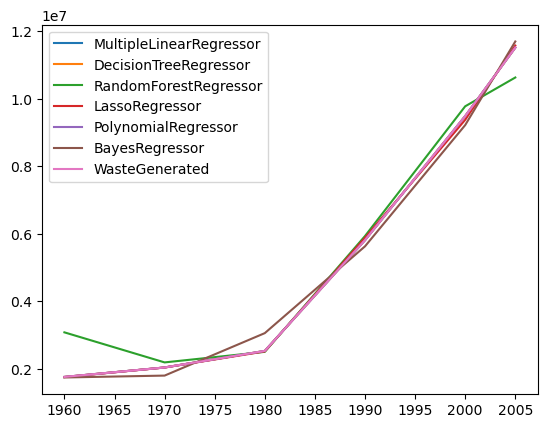

In [142]:
plt.plot('Date', 'MultipleLinearRegressor', data=train_ml)
plt.plot('Date', 'DecisionTreeRegressor', data=train_ml)
plt.plot('Date', 'RandomForestRegressor', data=train_ml)
plt.plot('Date', 'LassoRegressor', data=train_ml)
plt.plot('Date', 'PolynomialRegressor', data=train_ml)
plt.plot('Date', 'BayesRegressor', data=train_ml)
plt.plot('Date', 'WasteGenerated', data=train_ml)
plt.legend(loc='upper left')

In [143]:
fill_ml['Date'] = fill_ml['Date'].map(dt.datetime.toordinal)
validate_new = fill_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new.dropna(inplace=True)
x_new = validate_new
validate_new['DecisionTreeRegressor'] = model2.predict(x_new)
validate_new['Date'] = validate_new['Date'].map(dt.datetime.fromordinal)

In [144]:
validate_new2 = fill_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new2.dropna(inplace=True)
x_new2 = validate_new2
validate_new2['MultipleLinearRegressor'] = model.predict(x_new2)
validate_new2['Date'] = validate_new2['Date'].map(dt.datetime.fromordinal)


In [145]:
validate_new3 = fill_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new3.dropna(inplace=True)
x_new3 = validate_new3

validate_new3['RandomForestRegressor'] = regr.predict(x_new3)
validate_new3['Date'] = validate_new3['Date'].map(dt.datetime.fromordinal)


In [146]:
validate_new4 = fill_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new4.dropna(inplace=True)
x_new4 = validate_new4

validate_new4['LassoRegressor'] = lasso.predict(x_new4)
validate_new4['Date'] = validate_new4['Date'].map(dt.datetime.fromordinal)


In [147]:
validate_new5 = fill_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new5.dropna(inplace=True)
x_new5 = validate_new5

validate_new5['BayesRegressor'] = bayes.predict(x_new5)
validate_new5['Date'] = validate_new5['Date'].map(dt.datetime.fromordinal)


In [148]:
validate_new6 = fill_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new6.dropna(inplace=True)
x_new6 = validate_new6
poly_features = poly.fit_transform(x_new6)

validate_new6['PolynomialRegressor'] = poly_reg_model.predict(poly_features)
validate_new6['Date'] = validate_new6['Date'].map(dt.datetime.fromordinal)


In [149]:
validate_new7 = fill_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new7.dropna(inplace=True)
x_new7 = validate_new7

validate_new7['GradientBoostRegressor'] = grad.predict(x_new7)
validate_new7['Date'] = validate_new7['Date'].map(dt.datetime.fromordinal)


In [150]:
prediction1 = validate_new.merge(validate_new2.merge(
    validate_new3.merge(
    validate_new4.merge(
    validate_new5.merge(
    validate_new6.merge(
    validate_new7, how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']),
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE'])
filled_ml = pd.concat([train_ml, prediction1])
filled_ml.sort_values(by='Date', ascending=True, inplace=True)
filled_ml.reset_index(drop=True, inplace=True)
filled_ml

,Date,Rec,GDP,Inflation,PCE,WasteGenerated,MultipleLinearRegressor,DecisionTreeRegressor,RandomForestRegressor,LassoRegressor,PolynomialRegressor,BayesRegressor,GradientBoostRegressor
0,1960-01-01,0,542.648,1.457976,29.263,1760000.0,1.760000e+06,1760000.0,3.079683e+06,1.755237e+06,1.760000e+06,1.743736e+06,1.760128e+06
1,1961-01-01,1,545.018,1.070724,29.914,NaN,2.275389e+06,1760000.0,3.041983e+06,1.975642e+06,1.865460e+06,1.701924e+06,1.761269e+06
2,1962-01-01,0,594.013,1.198773,31.271,NaN,1.679451e+06,1760000.0,3.079683e+06,1.876107e+06,1.870291e+06,1.705698e+06,1.760128e+06
3,1963-01-01,0,621.672,1.239669,32.086,NaN,1.630719e+06,1760000.0,3.079683e+06,1.919166e+06,1.899514e+06,1.688651e+06,1.760128e+06
4,1964-01-01,0,669.822,1.278912,34.724,NaN,1.625467e+06,1760000.0,3.079683e+06,1.974402e+06,1.989788e+06,1.691677e+06,1.760128e+06
5,1965-01-01,0,717.790,1.585169,36.483,NaN,1.595034e+06,1760000.0,3.079683e+06,2.001240e+06,2.015863e+06,1.694350e+06,1.874124e+06
6,1966-01-01,0,795.734,3.015075,39.802,NaN,1.564760e+06,2040000.0,3.082483e+06,1.921006e+06,1.982822e+06,1.726424e+06,1.906663e+06
7,1967-01-01,0,844.170,2.772786,41.677,NaN,1.559210e+06,2040000.0,3.085283e+06,2.009788e+06,2.061370e+06,1.729690e+06,1.973003e+06
8,1968-01-01,0,909.387,4.271796,45.583,NaN,1.526290e+06,2040000.0,3.128683e+06,1.910798e+06,2.068293e+06,1.749393e+06,2.038950e+06
9,1969-01-01,0,993.337,5.462386,48.810,NaN,1.508447e+06,2040000.0,2.384333e+06,1.862440e+06,2.045621e+06,1.787198e+06,2.038950e+06


In [151]:
# make a table that outlines whether a prediction is under or over the actual
condensed_table = filled_ml[['Date', 'WasteGenerated','MultipleLinearRegressor', 'DecisionTreeRegressor',
       'RandomForestRegressor', 'LassoRegressor', 'PolynomialRegressor',
       'BayesRegressor', 'GradientBoostRegressor']].copy()
condensed_table_nonan = condensed_table[condensed_table['WasteGenerated'].isna() == False]
condensed_table_nonan['MLR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['MultipleLinearRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['MultipleLinearRegressor'], 'Equal','Over'))
condensed_table_nonan['DTR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['DecisionTreeRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['DecisionTreeRegressor'], 'Equal','Over'))
condensed_table_nonan['RFR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['RandomForestRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['RandomForestRegressor'], 'Equal','Over'))
condensed_table_nonan['LR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['LassoRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['LassoRegressor'], 'Equal','Over'))
condensed_table_nonan['PR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['PolynomialRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['PolynomialRegressor'], 'Equal','Over'))
condensed_table_nonan['BR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['BayesRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['BayesRegressor'], 'Equal','Over'))
condensed_table_nonan['GBR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['GradientBoostRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['GradientBoostRegressor'], 'Equal','Over'))
condensed_under_over = condensed_table_nonan[['Date', 'WasteGenerated','MLR_UnderOver', 'DTR_UnderOver', 'RFR_UnderOver', 'LR_UnderOver',
       'PR_UnderOver', 'BR_UnderOver', 'GBR_UnderOver']].copy()
condensed_under_over

C:\Users\billy\AppData\Local\Temp\ipykernel_22948\4156074415.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condensed_table_nonan['MLR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['MultipleLinearRegressor'],'Under',
C:\Users\billy\AppData\Local\Temp\ipykernel_22948\4156074415.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condensed_table_nonan['DTR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['DecisionTreeRegressor

,Date,WasteGenerated,MLR_UnderOver,DTR_UnderOver,RFR_UnderOver,LR_UnderOver,PR_UnderOver,BR_UnderOver,GBR_UnderOver
0,1960-01-01,1760000.0,Under,Equal,Under,Over,Over,Over,Under
10,1970-01-01,2040000.0,Under,Equal,Under,Over,Under,Over,Under
20,1980-01-01,2530000.0,Under,Equal,Over,Over,Equal,Under,Under
30,1990-01-01,5810000.0,Over,Equal,Under,Under,Equal,Over,Over
40,2000-01-01,9480000.0,Over,Equal,Under,Over,Under,Over,Over
45,2005-01-01,11510000.0,Over,Equal,Over,Under,Under,Under,Over


In [152]:
MLR_Under = condensed_under_over[condensed_under_over['MLR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
RFR_Under = condensed_under_over[condensed_under_over['RFR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
LR_Under = condensed_under_over[condensed_under_over['LR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
PR_Under = condensed_under_over[condensed_under_over['PR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
BR_Under = condensed_under_over[condensed_under_over['BR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
GBR_Under = condensed_under_over[condensed_under_over['GBR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]

MLR_Over = condensed_under_over[condensed_under_over['MLR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
RFR_Over = condensed_under_over[condensed_under_over['RFR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
LR_Over = condensed_under_over[condensed_under_over['LR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
PR_Over = condensed_under_over[condensed_under_over['PR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
BR_Over = condensed_under_over[condensed_under_over['BR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
GBR_Over = condensed_under_over[condensed_under_over['GBR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]

DTR_Equal = condensed_under_over[condensed_under_over['DTR_UnderOver'] == 'Equal'].shape[0]/condensed_under_over.shape[0]

Model = ['MultipleLinear', 'DecisionTree', 'RandomForest', 'Lasso','Polynomial','Bayes','GradientBoost']
Under = [MLR_Under, np.nan, RFR_Under, LR_Under, PR_Under, BR_Under, GBR_Under]
Over = [MLR_Over, np.nan, RFR_Over, LR_Over, PR_Over, BR_Over, GBR_Over]
Equal = [np.nan, DTR_Equal, np.nan, np.nan, np.nan, np.nan, np.nan]
R2 = [MLR_R2, DTR_R2, RFR_R2, LR_R2, PR_R2, BR_R2, GBR_R2]
MAE = [MLR_MAE, DTR_MAE, RFR_MAE, LR_MAE, PR_MAE, BR_MAE, GBR_MAE]
RMSE = [MLR_RMSE, DTR_RMSE, RFR_RMSE, LR_RMSE, PR_RMSE, BR_RMSE, GBR_RMSE]
F_stat = [MLR_f_statistic, DTR_p_value, RFR_f_statistic, LR_f_statistic, PR_f_statistic, BR_f_statistic, GBR_f_statistic]
p_value = [MLR_p_value, DTR_p_value, RFR_p_value, LR_p_value, PR_p_value, BR_p_value, GBR_p_value]
data = {'Model':Model, 'Under':Under, 'Over':Over, 'Equal':Equal, 'R2':R2, 'MAE':MAE, 'RMSE':RMSE, 'KW ML F-Stat':F_stat,'KW ML P-Value':p_value}

Results = pd.DataFrame(data=data)

Results.to_csv(Directory + 'Output/results_w_kw_ml.csv', index=False)

Results

,Model,Under,Over,Equal,R2,MAE,RMSE,KW ML F-Stat,KW ML P-Value
0,MultipleLinear,0.500000,0.500000,NaN,1.000000,3.973643e-07,4.664801e-07,0.000000,1.000000
1,DecisionTree,NaN,NaN,1.0,1.000000,0.000000e+00,0.000000e+00,1.000000,1.000000
2,RandomForest,0.666667,0.333333,NaN,0.969488,4.658306e+05,6.645117e+05,0.230769,0.630954
3,Lasso,0.333333,0.666667,NaN,0.999759,4.379719e+04,5.902128e+04,0.025641,0.872780
4,Polynomial,0.500000,0.166667,NaN,1.000000,3.725290e-09,4.809329e-09,0.025822,0.872337
5,Bayes,0.333333,0.666667,NaN,0.994562,2.355508e+05,2.805395e+05,0.025641,0.872780
6,GradientBoost,0.500000,0.500000,NaN,1.000000,9.061864e+01,1.031741e+02,0.000000,1.000000


In [153]:
filled_ml.to_csv(Directory + 'Output/ML_filled_train_set.csv', index=False)

# EDA

In [154]:
filled_ml.corr()

C:\Users\billy\AppData\Local\Temp\ipykernel_22948\1365886760.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  filled_ml.corr()


,Rec,GDP,Inflation,PCE,WasteGenerated,MultipleLinearRegressor,DecisionTreeRegressor,RandomForestRegressor,LassoRegressor,PolynomialRegressor,BayesRegressor,GradientBoostRegressor
Rec,1.000000,-0.112959,0.195589,-0.147360,-0.409292,-0.088597,-0.115342,-0.154128,-0.111311,-0.136900,-0.111035,-0.119206
GDP,-0.112959,1.000000,-0.429406,0.977412,0.995549,0.998259,0.918031,0.937337,0.998741,0.983605,0.999299,0.947505
Inflation,0.195589,-0.429406,1.000000,-0.405276,-0.351475,-0.459280,-0.450564,-0.547165,-0.471507,-0.444600,-0.441618,-0.462588
PCE,-0.147360,0.977412,-0.405276,1.000000,0.979636,0.979066,0.950933,0.963674,0.977105,0.943954,0.969915,0.966824
WasteGenerated,-0.409292,0.995549,-0.351475,0.979636,1.000000,1.000000,1.000000,0.989637,0.999880,1.000000,0.997281,1.000000
MultipleLinearRegressor,-0.088597,0.998259,-0.459280,0.979066,1.000000,1.000000,0.926291,0.947269,0.998851,0.981181,0.997814,0.953735
DecisionTreeRegressor,-0.115342,0.918031,-0.450564,0.950933,1.000000,0.926291,1.000000,0.977890,0.921987,0.857039,0.910725,0.993582
RandomForestRegressor,-0.154128,0.937337,-0.547165,0.963674,0.989637,0.947269,0.977890,1.000000,0.945541,0.883760,0.931925,0.985811
LassoRegressor,-0.111311,0.998741,-0.471507,0.977105,0.999880,0.998851,0.921987,0.945541,1.000000,0.982009,0.998275,0.950897
PolynomialRegressor,-0.136900,0.983605,-0.444600,0.943954,1.000000,0.981181,0.857039,0.883760,0.982009,1.000000,0.986537,0.892698


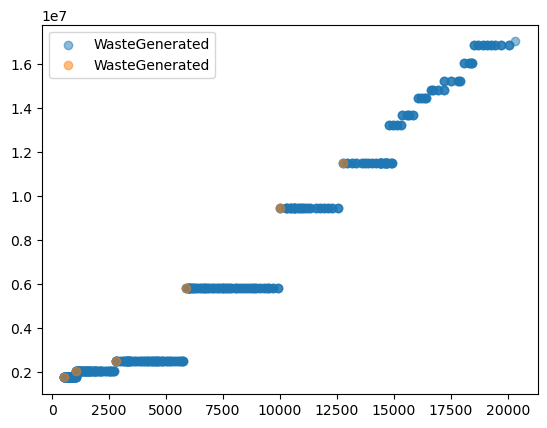

In [155]:
plt.scatter('GDP','WasteGenerated',data=full_ff, alpha=0.5)
plt.scatter('GDP','WasteGenerated',data=filled_ml, alpha=0.5)
plt.legend(loc='upper left')

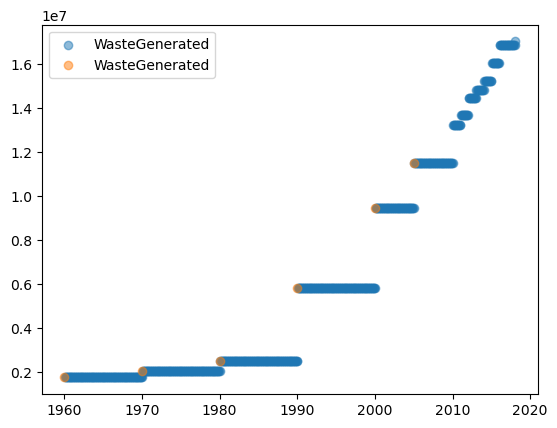

In [156]:
plt.scatter('Date','WasteGenerated',data=full_ff, alpha=0.5)
plt.scatter('Date','WasteGenerated',data=filled_ml, alpha=0.5)
plt.legend(loc='upper left')

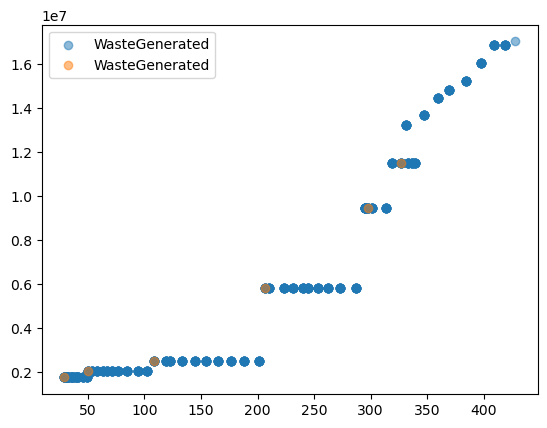

In [157]:
plt.scatter('PCE','WasteGenerated',data=full_ff, alpha=0.5)
plt.scatter('PCE','WasteGenerated',data=filled_ml, alpha=0.5)
plt.legend(loc='upper left')

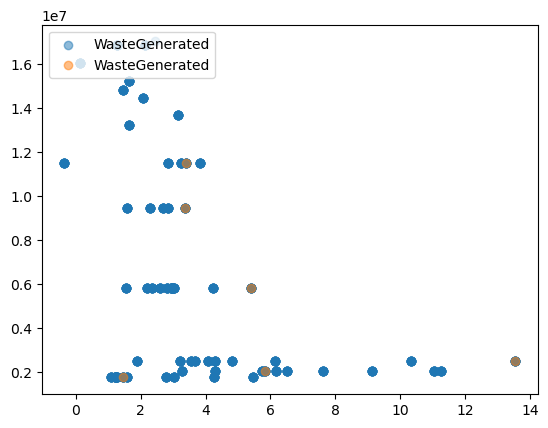

In [158]:
plt.scatter('Inflation','WasteGenerated',data=full_ff, alpha=0.5)
plt.scatter('Inflation','WasteGenerated',data=filled_ml, alpha=0.5)
plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x19ea2c027a0>,
 'caps': [<matplotlib.lines.Line2D at 0x19e9e6dd4b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x19ea2c028f0>],
 'medians': [<matplotlib.lines.Line2D at 0x19ea2b05900>],
 'fliers': [<matplotlib.lines.Line2D at 0x19ea2b07d00>],
 'means': []}

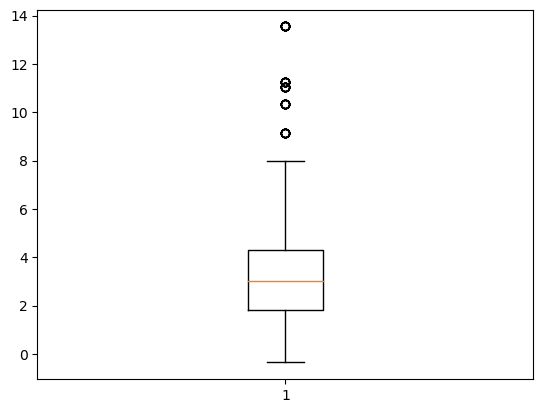

In [159]:
plt.boxplot('Inflation',data=full_ff)

I want to test both normalized data and not-normalized data.

Index(['Date', 'Rec', 'GDP', 'Inflation', 'PCE', 'WasteGenerated',
       'MultipleLinearRegressor', 'DecisionTreeRegressor',
       'RandomForestRegressor', 'LassoRegressor', 'PolynomialRegressor',
       'BayesRegressor', 'GradientBoostRegressor'],
      dtype='object')


C:\Users\billy\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+10, tolerance: 8.683e+09
  model = cd_fast.enet_coordinate_descent(


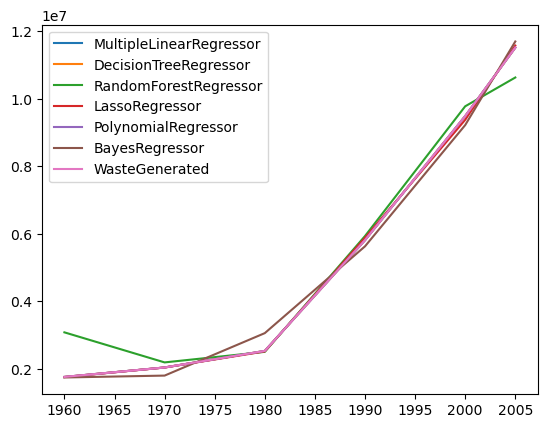

In [160]:
# Normalized Machine Learning Fill

Directory = 'C:/Users/billy/Documents/Homework/Data Practicum/Project/DataPracticum1/'

# Quarterly
fileGDP = pd.read_csv(Directory + 'Inputs/GDP.csv', names=['Date', 'GDP'], header=0)

# Monthly
fileRecession = pd.read_csv(Directory + 'Inputs/USREC.csv', names=['Date','Rec'], header=0)

#Yearly
filePCE = pd.read_csv(Directory + 'Inputs/PCE.csv',
                                              names=['Date', 'PCE'],
                                              header=0)

fileInflation = pd.read_csv(Directory + 'Inputs/Inflation.csv',
                            names=['Date', 'Inflation'], header=0)

fileWasteGenerated = pd.read_excel(Directory + 'Inputs/Materials_Municipal_Waste_Stream_1960_2018.xlsx',
                                   sheet_name='Materials generated', index_col=0)

filePCE.Date = pd.to_datetime(filePCE.Date, errors='coerce')
fileInflation.Date = pd.to_datetime(fileInflation.Date, errors='coerce')
fileGDP.Date = pd.to_datetime(fileGDP.Date, errors='coerce')

fileWasteGenerated = fileWasteGenerated.T
fileWasteGenerated = fileWasteGenerated[['Products - Textiles']].copy()
fileWasteGenerated.reset_index(inplace=True)
fileWasteGenerated.rename(columns={'index':'Date',
                                   'Products - Textiles':'WasteGenerated'},
                          inplace=True)
fileWasteGenerated.Date = pd.to_datetime(fileWasteGenerated.Date)

fileRecession.Date = pd.to_datetime(fileRecession.Date, errors='coerce')

fileCPI.Date = pd.to_datetime(fileCPI.Date, errors='coerce')


df = fileRecession.merge(
    fileGDP, how='left').merge(
    fileInflation, how='left').merge(
    filePCE, how='left').merge(
    fileWasteGenerated, how='left')

normal_ml = df.copy()
normal_ml['Rec'] =( normal_ml['Rec']-normal_ml['Rec'].mean() ) / normal_ml['Rec'].std()
normal_ml['GDP'] =( normal_ml['GDP']-normal_ml['GDP'].mean() ) / normal_ml['GDP'].std()
normal_ml['Inflation'] =( normal_ml['Inflation']-normal_ml['Inflation'].mean() ) / normal_ml['Inflation'].std()
normal_ml['PCE'] =( normal_ml['PCE']-normal_ml['PCE'].mean() ) / normal_ml['PCE'].std()

normal_full_ml = df[(df['Date'] >= '1960-01-01') & (df['Date'] <= '2022-01-31')].copy().reset_index(drop=True)
normal_train_ml = df[(df['Date'] >= '1960-01-01') & 
                   (df['Date'] <= '2018-01-31') & 
                   (df['WasteGenerated'].isna() == False)].copy().reset_index(drop=True)
normal_fill_ml = df[(df['Date'] >= '1960-01-31') & 
                   (df['Date'] <= '2018-01-31') & 
                   (df['WasteGenerated'].isna() == True)].copy().reset_index(drop=True)
normal_fill_ml.dropna(subset=['GDP', 'Inflation', 'PCE'], inplace=True)
normal_validate_ml = df[(df['Date'] > '2018-01-31')].copy().reset_index(drop=True)

print(train_ml.columns)

normal_full_ml.to_csv(Directory + 'Output/Full ML filled data set.csv', index=False)
normal_train_ml.to_csv(Directory + 'Output/Train ML filled data set.csv', index=False)
normal_fill_ml.to_csv(Directory + 'Output/Fill ML filled data set.csv', index=False)
normal_validate_ml.to_csv(Directory + 'Output/validation ML filled data set.csv', index=False)

x_1 = train_ml.iloc[:,0:5]
y_1 = train_ml.iloc[:,5]
normal_fill_ml = normal_fill_ml[['Date','Rec','GDP','Inflation','PCE']].copy()

model = LinearRegression()
x_1['Date']=x_1['Date'].map(dt.datetime.toordinal)
model.fit(x_1, y_1)
normal_train_ml['MultipleLinearRegressor'] = model.predict(x_1)
y_true = normal_train_ml['WasteGenerated']
y_pred = normal_train_ml['MultipleLinearRegressor']
MLR_anova = f_oneway(y_true, y_pred)
MLR_f_statistic = MLR_anova[0]
MLR_p_value = MLR_anova[1]
MLR_R2 = r2_score(y_true, y_pred)
MLR_MAE = mean_absolute_error(y_true, y_pred)
MLR_RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
MLR_R2, MLR_MAE, MLR_RMSE, MLR_f_statistic, MLR_p_value

model2 = DecisionTreeRegressor()
model2.fit(x_1, y_1)
normal_train_ml['DecisionTreeRegressor'] = model2.predict(x_1)
yhat = normal_train_ml['DecisionTreeRegressor']
DTR_R2 = r2_score(y_true, yhat) 
DTR_MAE = mean_absolute_error(y_true, yhat)
DTR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
DTR_anova = f_oneway(y_true, yhat)
DTR_f_statistic = DTR_anova[0]
DTR_p_value = DTR_anova[1]
DTR_R2 = r2_score(y_true, yhat)
DTR_MAE = mean_absolute_error(y_true, yhat)
DTR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
DTR_R2, DTR_MAE, DTR_RMSE, DTR_f_statistic, DTR_p_value

regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x_1, y_1)

normal_train_ml['RandomForestRegressor'] = regr.predict(x_1)
yhat = normal_train_ml['RandomForestRegressor']
RFR_anova = f_oneway(y_true, yhat)
RFR_f_statistic = RFR_anova[0]
RFR_p_value = RFR_anova[1]
RFR_R2 = r2_score(y_true, yhat)
RFR_MAE = mean_absolute_error(y_true, yhat)
RFR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
RFR_R2, RFR_MAE, RFR_RMSE, RFR_f_statistic, RFR_p_value

lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(x_1, y_1)

normal_train_ml['LassoRegressor'] = lasso.predict(x_1)
yhat = normal_train_ml['LassoRegressor']
lasso_anova = f_oneway(y_true, yhat)
lasso_f_statistic = lasso_anova[0]
lasso_p_value = lasso_anova[1]
LR_R2 = r2_score(y_true, yhat)
LR_MAE = mean_absolute_error(y_true, yhat)
LR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
LR_R2, LR_MAE, LR_RMSE, lasso_f_statistic, lasso_p_value

#specify degree of 3 for polynomial regression model
#include bias=False means don't force y-intercept to equal zero
poly = PolynomialFeatures(degree=3, include_bias=False)

#reshape data to work properly with sklearn
poly_features = poly.fit_transform(x_1)

#fit polynomial regression model
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_1)

normal_train_ml['PolynomialRegressor'] = poly_reg_model.predict(poly_features)
yhat = normal_train_ml['PolynomialRegressor']
poly_anova = f_oneway(y_true, yhat)
poly_f_statistic = poly_anova[0]
poly_p_value = poly_anova[1]
PR_R2 = r2_score(y_true, yhat)
PR_MAE = mean_absolute_error(y_true, yhat)
PR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
PR_R2, PR_MAE, PR_RMSE, poly_f_statistic, poly_p_value

bayes = linear_model.BayesianRidge()
bayes.fit(x_1, y_1)

normal_train_ml['BayesRegressor'] = bayes.predict(x_1)
yhat = normal_train_ml['BayesRegressor']
BR_R2 = r2_score(y_true, yhat) 
BR_MAE = mean_absolute_error(y_true, yhat)
BR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
bayes_anova = f_oneway(y_true, yhat)
bayes_f_statistic = bayes_anova[0]
bayes_p_value = bayes_anova[1]
BR_R2 = r2_score(y_true, yhat)
BR_MAE = mean_absolute_error(y_true, yhat)
BR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
BR_R2, BR_MAE, BR_RMSE, bayes_f_statistic, bayes_p_value

grad = GradientBoostingRegressor(random_state=0)
grad.fit(x_1,y_1)

normal_train_ml['GradientBoostRegressor'] = grad.predict(x_1)
yhat = normal_train_ml['GradientBoostRegressor']
grad_anova = f_oneway(y_true, yhat)
grad_f_statistic = grad_anova[0]
grad_p_value = grad_anova[1]
GBR_R2 = r2_score(y_true, yhat)
GBR_MAE = mean_absolute_error(y_true, yhat)
GBR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
GBR_R2, GBR_MAE, GBR_RMSE, grad_f_statistic, grad_p_value

plt.plot('Date', 'MultipleLinearRegressor', data=normal_train_ml)
plt.plot('Date', 'DecisionTreeRegressor', data=normal_train_ml)
plt.plot('Date', 'RandomForestRegressor', data=normal_train_ml)
plt.plot('Date', 'LassoRegressor', data=normal_train_ml)
plt.plot('Date', 'PolynomialRegressor', data=normal_train_ml)
plt.plot('Date', 'BayesRegressor', data=normal_train_ml)
plt.plot('Date', 'WasteGenerated', data=normal_train_ml)
plt.legend(loc='upper left')

normal_fill_ml['Date'] = normal_fill_ml['Date'].map(dt.datetime.toordinal)
validate_new = normal_fill_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new.dropna(inplace=True)
x_new = validate_new
validate_new['DecisionTreeRegressor'] = model2.predict(x_new)
validate_new['Date'] = validate_new['Date'].map(dt.datetime.fromordinal)
validate_new

validate_new2 = normal_fill_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new2.dropna(inplace=True)
x_new2 = validate_new2
validate_new2['MultipleLinearRegressor'] = model.predict(x_new2)
validate_new2['Date'] = validate_new2['Date'].map(dt.datetime.fromordinal)
validate_new2

validate_new3 = normal_fill_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new3.dropna(inplace=True)
x_new3 = validate_new3

validate_new3['RandomForestRegressor'] = regr.predict(x_new3)
validate_new3['Date'] = validate_new3['Date'].map(dt.datetime.fromordinal)
validate_new3

validate_new4 = normal_fill_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new4.dropna(inplace=True)
x_new4 = validate_new4

validate_new4['LassoRegressor'] = lasso.predict(x_new4)
validate_new4['Date'] = validate_new4['Date'].map(dt.datetime.fromordinal)
validate_new4

validate_new5 = normal_fill_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new5.dropna(inplace=True)
x_new5 = validate_new5

validate_new5['BayesRegressor'] = bayes.predict(x_new5)
validate_new5['Date'] = validate_new5['Date'].map(dt.datetime.fromordinal)
validate_new5

validate_new6 = normal_fill_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new6.dropna(inplace=True)
x_new6 = validate_new6
poly_features = poly.fit_transform(x_new6)

validate_new6['PolynomialRegressor'] = poly_reg_model.predict(poly_features)
validate_new6['Date'] = validate_new6['Date'].map(dt.datetime.fromordinal)
validate_new6

validate_new7 = normal_fill_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new7.dropna(inplace=True)
x_new7 = validate_new7

validate_new7['GradientBoostRegressor'] = grad.predict(x_new7)
validate_new7['Date'] = validate_new7['Date'].map(dt.datetime.fromordinal)
validate_new7

normal_prediction1 = validate_new.merge(validate_new2.merge(
    validate_new3.merge(
    validate_new4.merge(
    validate_new5.merge(
    validate_new6.merge(
    validate_new7, how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']),
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE'])
normal_filled_ml = pd.concat([normal_train_ml, normal_prediction1])
normal_filled_ml.sort_values(by='Date', ascending=True, inplace=True)
normal_filled_ml.reset_index(drop=True, inplace=True)
normal_filled_ml

normal_filled_ml.to_csv(Directory + 'Output/Normalized_ML_filled_train_set.csv', index=False)

In [161]:
# make a table that outlines whether a prediction is under or over the actual
condensed_table = normal_filled_ml[['Date', 'WasteGenerated','MultipleLinearRegressor', 'DecisionTreeRegressor',
       'RandomForestRegressor', 'LassoRegressor', 'PolynomialRegressor',
       'BayesRegressor', 'GradientBoostRegressor']].copy()
condensed_table_nonan = condensed_table[condensed_table['WasteGenerated'].isna() == False]
condensed_table_nonan['MLR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['MultipleLinearRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['MultipleLinearRegressor'], 'Equal','Over'))
condensed_table_nonan['DTR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['DecisionTreeRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['DecisionTreeRegressor'], 'Equal','Over'))
condensed_table_nonan['RFR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['RandomForestRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['RandomForestRegressor'], 'Equal','Over'))
condensed_table_nonan['LR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['LassoRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['LassoRegressor'], 'Equal','Over'))
condensed_table_nonan['PR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['PolynomialRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['PolynomialRegressor'], 'Equal','Over'))
condensed_table_nonan['BR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['BayesRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['BayesRegressor'], 'Equal','Over'))
condensed_table_nonan['GBR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['GradientBoostRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['GradientBoostRegressor'], 'Equal','Over'))
condensed_under_over = condensed_table_nonan[['Date', 'WasteGenerated','MLR_UnderOver', 'DTR_UnderOver', 'RFR_UnderOver', 'LR_UnderOver',
       'PR_UnderOver', 'BR_UnderOver', 'GBR_UnderOver']].copy()
condensed_under_over

C:\Users\billy\AppData\Local\Temp\ipykernel_22948\34390622.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condensed_table_nonan['MLR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['MultipleLinearRegressor'],'Under',
C:\Users\billy\AppData\Local\Temp\ipykernel_22948\34390622.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condensed_table_nonan['DTR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['DecisionTreeRegressor'],'

,Date,WasteGenerated,MLR_UnderOver,DTR_UnderOver,RFR_UnderOver,LR_UnderOver,PR_UnderOver,BR_UnderOver,GBR_UnderOver
0,1960-01-01,1760000.0,Under,Equal,Under,Over,Over,Over,Under
10,1970-01-01,2040000.0,Under,Equal,Under,Over,Under,Over,Under
20,1980-01-01,2530000.0,Under,Equal,Over,Over,Equal,Under,Under
30,1990-01-01,5810000.0,Over,Equal,Under,Under,Equal,Over,Over
40,2000-01-01,9480000.0,Over,Equal,Under,Over,Under,Over,Over
45,2005-01-01,11510000.0,Over,Equal,Over,Under,Under,Under,Over


In [162]:
MLR_Under = condensed_under_over[condensed_under_over['MLR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
RFR_Under = condensed_under_over[condensed_under_over['RFR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
LR_Under = condensed_under_over[condensed_under_over['LR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
PR_Under = condensed_under_over[condensed_under_over['PR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
BR_Under = condensed_under_over[condensed_under_over['BR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
GBR_Under = condensed_under_over[condensed_under_over['GBR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]

MLR_Over = condensed_under_over[condensed_under_over['MLR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
RFR_Over = condensed_under_over[condensed_under_over['RFR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
LR_Over = condensed_under_over[condensed_under_over['LR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
PR_Over = condensed_under_over[condensed_under_over['PR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
BR_Over = condensed_under_over[condensed_under_over['BR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
GBR_Over = condensed_under_over[condensed_under_over['GBR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]

DTR_Equal = condensed_under_over[condensed_under_over['DTR_UnderOver'] == 'Equal'].shape[0]/condensed_under_over.shape[0]
PR_Equal = condensed_under_over[condensed_under_over['PR_UnderOver'] == 'Equal'].shape[0]/condensed_under_over.shape[0]

Model = ['MultipleLinear', 'DecisionTree', 'RandomForest', 'Lasso','Polynomial','Bayes','GradientBoost']
Under = [MLR_Under, np.nan, RFR_Under, LR_Under, PR_Under, BR_Under, GBR_Under]
Over = [MLR_Over, np.nan, RFR_Over, LR_Over, PR_Over, BR_Over, GBR_Over]
Equal = [np.nan, DTR_Equal, np.nan, np.nan, PR_Equal, np.nan, np.nan]
R2 = [MLR_R2, DTR_R2, RFR_R2, LR_R2, PR_R2, BR_R2, GBR_R2]
MAE = [MLR_MAE, DTR_MAE, RFR_MAE, LR_MAE, PR_MAE, BR_MAE, GBR_MAE]
RMSE = [MLR_RMSE, DTR_RMSE, RFR_RMSE, LR_RMSE, PR_RMSE, BR_RMSE, GBR_RMSE]
F_stat = [MLR_f_statistic, DTR_f_statistic, RFR_f_statistic, lasso_f_statistic, poly_f_statistic, bayes_f_statistic, grad_f_statistic]
p_value = [MLR_p_value, DTR_p_value, RFR_p_value, lasso_p_value, poly_p_value, bayes_p_value, grad_p_value]
data = {'Model':Model, 'Under':Under, 'Over':Over, 'Equal':Equal, 'R2':R2, 'MAE':MAE, 'RMSE':RMSE, 'ANOVA ML F-Stat':F_stat,'ANOVA ML P-Value':p_value}

Results = pd.DataFrame(data=data)

Results.to_csv(Directory + 'Output/results_w_ml_anova.csv', index=False)

Results

,Model,Under,Over,Equal,R2,MAE,RMSE,ANOVA ML F-Stat,ANOVA ML P-Value
0,MultipleLinear,0.500000,0.500000,NaN,1.000000,3.973643e-07,4.664801e-07,2.726762e-28,1.00000
1,DecisionTree,NaN,NaN,1.000000,1.000000,0.000000e+00,0.000000e+00,-8.323956e-32,NaN
2,RandomForest,0.666667,0.333333,NaN,0.969488,4.658306e+05,6.645117e+05,4.965833e-03,0.94521
3,Lasso,0.333333,0.666667,NaN,0.999759,4.379719e+04,5.902128e+04,6.656578e-30,1.00000
4,Polynomial,0.500000,0.166667,0.333333,1.000000,3.725290e-09,4.809329e-09,1.065466e-30,1.00000
5,Bayes,0.333333,0.666667,NaN,0.994562,2.355508e+05,2.805395e+05,-8.368868e-32,NaN
6,GradientBoost,0.500000,0.500000,NaN,1.000000,9.061864e+01,1.031741e+02,1.664836e-32,1.00000


In [163]:
# Normalized Data Sets
normal_train_test_ff = train_test_ff.copy()
normal_train_test_ff['Rec'] =( normal_train_test_ff['Rec']-normal_train_test_ff['Rec'].mean() ) / normal_train_test_ff['Rec'].std()
normal_train_test_ff['GDP'] =( normal_train_test_ff['GDP']-normal_train_test_ff['GDP'].mean() ) / normal_train_test_ff['GDP'].std()
normal_train_test_ff['Inflation'] =( normal_train_test_ff['Inflation']-normal_train_test_ff['Inflation'].mean() ) / normal_train_test_ff['Inflation'].std()
normal_train_test_ff['PCE'] =( normal_train_test_ff['PCE']-train_test_ff['PCE'].mean() ) / normal_train_test_ff['PCE'].std()

normal_filled_ml

# Not-Normalized
train_test_ff
filled_ml

,Date,Rec,GDP,Inflation,PCE,WasteGenerated,MultipleLinearRegressor,DecisionTreeRegressor,RandomForestRegressor,LassoRegressor,PolynomialRegressor,BayesRegressor,GradientBoostRegressor
0,1960-01-01,0,542.648,1.457976,29.263,1760000.0,1.760000e+06,1760000.0,3.079683e+06,1.755237e+06,1.760000e+06,1.743736e+06,1.760128e+06
1,1961-01-01,1,545.018,1.070724,29.914,NaN,2.275389e+06,1760000.0,3.041983e+06,1.975642e+06,1.865460e+06,1.701924e+06,1.761269e+06
2,1962-01-01,0,594.013,1.198773,31.271,NaN,1.679451e+06,1760000.0,3.079683e+06,1.876107e+06,1.870291e+06,1.705698e+06,1.760128e+06
3,1963-01-01,0,621.672,1.239669,32.086,NaN,1.630719e+06,1760000.0,3.079683e+06,1.919166e+06,1.899514e+06,1.688651e+06,1.760128e+06
4,1964-01-01,0,669.822,1.278912,34.724,NaN,1.625467e+06,1760000.0,3.079683e+06,1.974402e+06,1.989788e+06,1.691677e+06,1.760128e+06
5,1965-01-01,0,717.790,1.585169,36.483,NaN,1.595034e+06,1760000.0,3.079683e+06,2.001240e+06,2.015863e+06,1.694350e+06,1.874124e+06
6,1966-01-01,0,795.734,3.015075,39.802,NaN,1.564760e+06,2040000.0,3.082483e+06,1.921006e+06,1.982822e+06,1.726424e+06,1.906663e+06
7,1967-01-01,0,844.170,2.772786,41.677,NaN,1.559210e+06,2040000.0,3.085283e+06,2.009788e+06,2.061370e+06,1.729690e+06,1.973003e+06
8,1968-01-01,0,909.387,4.271796,45.583,NaN,1.526290e+06,2040000.0,3.128683e+06,1.910798e+06,2.068293e+06,1.749393e+06,2.038950e+06
9,1969-01-01,0,993.337,5.462386,48.810,NaN,1.508447e+06,2040000.0,2.384333e+06,1.862440e+06,2.045621e+06,1.787198e+06,2.038950e+06


# Modeling with Normalized Data Sets

Forward Filled

In [164]:
normal_validation = validate_ff.copy()
normal_validation['Rec'] =( normal_validation['Rec']-normal_validation['Rec'].mean() ) / normal_validation['Rec'].std()
normal_validation['GDP'] =( normal_validation['GDP']-normal_validation['GDP'].mean() ) / normal_validation['GDP'].std()
normal_validation['Inflation'] =( normal_validation['Inflation']-normal_validation['Inflation'].mean() ) / normal_validation['Inflation'].std()
normal_validation['PCE'] =( normal_validation['PCE']-normal_validation['PCE'].mean() ) / normal_validation['PCE'].std()

In [165]:
normal_train_test_ff = normal_train_test_ff[['Date', 'Rec', 'GDP', 'Inflation', 'PCE', 'WasteGenerated']].copy()
normal_train_test_ff['Date']=normal_train_test_ff['Date'].map(dt.datetime.toordinal)
normal_train_test_ff.dropna(inplace=True)
ff_x = normal_train_test_ff.iloc[:,:-1]
ff_y = normal_train_test_ff.WasteGenerated

In [166]:
model = LinearRegression()
model.fit(ff_x, ff_y)
normal_train_test_ff['MultipleLinearRegressor'] = model.predict(ff_x)
y_true = normal_train_test_ff['WasteGenerated']
y_pred = normal_train_test_ff['MultipleLinearRegressor']

 # Conduct the one-way ANOVA
MLR_anova = f_oneway(y_true, y_pred)
MLR_f_statistic = MLR_anova[0]
MLR_p_value = MLR_anova[1]
MLR_R2 = r2_score(y_true, y_pred)
MLR_MAE = mean_absolute_error(y_true, y_pred)
MLR_RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
MLR_R2, MLR_MAE, MLR_RMSE, MLR_f_statistic, MLR_p_value

(0.9796433344477827,
 529894.7857921491,
 691589.8674105547,
 4.2037654872727975e-27,
 1.0)

In [167]:
model2 = DecisionTreeRegressor()
model2.fit(ff_x, ff_y)
normal_train_test_ff['DecisionTreeRegressor'] = model2.predict(ff_x)
yhat = normal_train_test_ff['DecisionTreeRegressor']
# Conduct the one-way ANOVA
DTR_anova = f_oneway(y_true, yhat)
DTR_f_statistic = DTR_anova[0]
DTR_p_value = DTR_anova[1]
DTR_R2 = r2_score(y_true, yhat)
DTR_MAE = mean_absolute_error(y_true, yhat)
DTR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
DTR_R2, DTR_MAE, DTR_RMSE, DTR_f_statistic, DTR_p_value

(1.0, 0.0, 0.0, 2.5995282152627723e-29, 1.0)

In [168]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(ff_x, ff_y)

normal_train_test_ff['RandomForestRegressor'] = regr.predict(ff_x)
yhat = normal_train_test_ff['RandomForestRegressor']
RFR_anova = f_oneway(y_true, yhat)
RFR_f_statistic = RFR_anova[0]
RFR_p_value = RFR_anova[1]
RFR_R2 = r2_score(y_true, yhat)
RFR_MAE = mean_absolute_error(y_true, yhat)
RFR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
RFR_R2, RFR_MAE, RFR_RMSE, RFR_f_statistic, RFR_p_value

(0.9808426828213955,
 469312.43729355023,
 670907.4984605107,
 9.457689950041572e-05,
 0.9922420361982269)

In [169]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(ff_x, ff_y)

normal_train_test_ff['LassoRegressor'] = lasso.predict(ff_x)
yhat = normal_train_test_ff['LassoRegressor']
lasso_anova = f_oneway(y_true, yhat)
lasso_f_statistic = lasso_anova[0]
lasso_p_value = lasso_anova[1]
LR_R2 = r2_score(y_true, yhat)
LR_MAE = mean_absolute_error(y_true, yhat)
LR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
LR_R2, LR_MAE, LR_RMSE, lasso_f_statistic, lasso_p_value

C:\Users\billy\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e+14, tolerance: 1.638e+12
  model = cd_fast.enet_coordinate_descent(


(0.9796433344433338,
 529893.2888804112,
 691589.8674861273,
 2.479363016960233e-26,
 1.0)

In [170]:
#specify degree of 3 for polynomial regression model
#include bias=False means don't force y-intercept to equal zero
poly = PolynomialFeatures(degree=3, include_bias=False)

#reshape data to work properly with sklearn
poly_features = poly.fit_transform(ff_x)

#fit polynomial regression model
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, ff_y)

normal_train_test_ff['PolynomialRegressor'] = poly_reg_model.predict(poly_features)
yhat = normal_train_test_ff['PolynomialRegressor']
poly_anova = f_oneway(y_true, yhat)
poly_f_statistic = poly_anova[0]
poly_p_value = poly_anova[1]
PR_R2 = r2_score(y_true, yhat)
PR_MAE = mean_absolute_error(y_true, yhat)
PR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
PR_R2, PR_MAE, PR_RMSE, poly_f_statistic, poly_p_value

(0.9878198496966027,
 372017.3284936711,
 534960.3874714862,
 5.544423039443077e-22,
 1.0)

In [171]:
bayes = linear_model.BayesianRidge()
bayes.fit(ff_x, ff_y)

normal_train_test_ff['BayesRegressor'] = bayes.predict(ff_x)
yhat = normal_train_test_ff['BayesRegressor']
bayes_anova = f_oneway(y_true, yhat)
bayes_f_statistic = bayes_anova[0]
bayes_p_value = bayes_anova[1]
BR_R2 = r2_score(y_true, yhat)
BR_MAE = mean_absolute_error(y_true, yhat)
BR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
BR_R2, BR_MAE, BR_RMSE, bayes_f_statistic, bayes_p_value

(0.8399813650021926,
 1640354.6125033821,
 1939012.3790107027,
 8.309913793759401e-26,
 1.0)

In [172]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

grad = ensemble.GradientBoostingRegressor(**params)
grad.fit(ff_x, ff_y)

normal_train_test_ff['GradientBoostRegressor'] = grad.predict(ff_x)
yhat = normal_train_test_ff['GradientBoostRegressor']
grad_anova = f_oneway(y_true, yhat)
grad_f_statistic = grad_anova[0]
grad_p_value = grad_anova[1]
GBR_R2 = r2_score(y_true, yhat)
GBR_MAE = mean_absolute_error(y_true, yhat)
GBR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
GBR_R2, GBR_MAE, GBR_RMSE, grad_f_statistic, grad_p_value

(0.9999565527205702,
 26921.13716865362,
 31950.42169507458,
 -1.744467981741816e-29,
 nan)

In [173]:
normal_train_test_ff['Date']=normal_train_test_ff['Date'].map(dt.datetime.fromordinal)

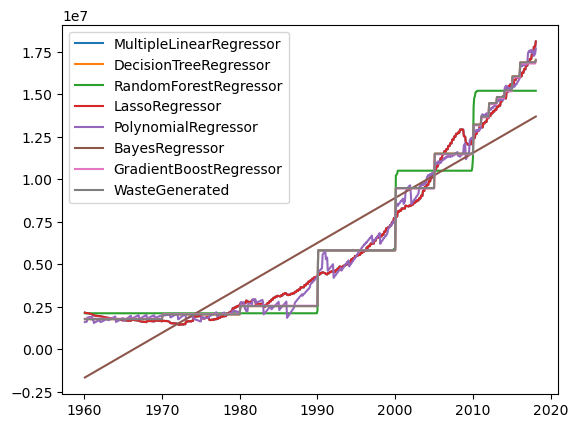

In [174]:
plt.plot('Date', 'MultipleLinearRegressor', data=normal_train_test_ff)
plt.plot('Date', 'DecisionTreeRegressor', data=normal_train_test_ff)
plt.plot('Date', 'RandomForestRegressor', data=normal_train_test_ff)
plt.plot('Date', 'LassoRegressor', data=normal_train_test_ff)
plt.plot('Date', 'PolynomialRegressor', data=normal_train_test_ff)
plt.plot('Date', 'BayesRegressor', data=normal_train_test_ff)
plt.plot('Date', 'GradientBoostRegressor', data=normal_train_test_ff)
plt.plot('Date', 'WasteGenerated', data=normal_train_test_ff)
plt.legend(loc='upper left')

In [175]:
normal_validation['Date'] = normal_validation['Date'].map(dt.datetime.toordinal)
validate_new = normal_validation[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new.dropna(inplace=True)
x_new = validate_new
validate_new['DecisionTreeRegressor'] = model2.predict(x_new)
validate_new['Date'] = validate_new['Date'].map(dt.datetime.fromordinal)

In [176]:
validate_new2 = normal_validation[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new2.dropna(inplace=True)
x_new2 = validate_new2
validate_new2['MultipleLinearRegressor'] = model.predict(x_new2)
validate_new2['Date'] = validate_new2['Date'].map(dt.datetime.fromordinal)

In [177]:
validate_new3 = normal_validation[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new3.dropna(inplace=True)
x_new3 = validate_new3

validate_new3['RandomForestRegressor'] = regr.predict(x_new3)
validate_new3['Date'] = validate_new3['Date'].map(dt.datetime.fromordinal)


In [178]:
validate_new4 = normal_validation[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new4.dropna(inplace=True)
x_new4 = validate_new4

validate_new4['LassoRegressor'] = lasso.predict(x_new4)
validate_new4['Date'] = validate_new4['Date'].map(dt.datetime.fromordinal)


In [179]:
validate_new5 = normal_validation[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new5.dropna(inplace=True)
x_new5 = validate_new5

validate_new5['BayesRegressor'] = bayes.predict(x_new5)
validate_new5['Date'] = validate_new5['Date'].map(dt.datetime.fromordinal)


In [180]:
validate_new6 = normal_validation[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new6.dropna(inplace=True)
x_new6 = validate_new6
poly_features = poly.fit_transform(x_new6)

validate_new6['PolynomialRegressor'] = poly_reg_model.predict(poly_features)
validate_new6['Date'] = validate_new6['Date'].map(dt.datetime.fromordinal)


In [181]:
validate_new7 = normal_validation[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new7.dropna(inplace=True)
x_new7 = validate_new7

validate_new7['GradientBoostRegressor'] = grad.predict(x_new7)
validate_new7['Date'] = validate_new7['Date'].map(dt.datetime.fromordinal)


In [182]:
normal_ff_prediction = validate_new.merge(validate_new2.merge(
    validate_new3.merge(
    validate_new4.merge(
    validate_new5.merge(
    validate_new6.merge(
    validate_new7, how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']),
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE'])
normal_ff_prediction = pd.concat([normal_train_test_ff, normal_ff_prediction])
normal_ff_prediction

,Date,Rec,GDP,Inflation,PCE,WasteGenerated,MultipleLinearRegressor,DecisionTreeRegressor,RandomForestRegressor,LassoRegressor,PolynomialRegressor,BayesRegressor,GradientBoostRegressor
0,1960-01-31,-0.392113,-1.104304,-0.831343,-1.329503,1760000.0,2.146040e+06,1760000.0,2.108940e+06,2.146020e+06,1.589018e+06,-1.670988e+06,1.787923e+06
1,1960-02-29,-0.392113,-1.104304,-0.831343,-1.329503,1760000.0,2.136068e+06,1760000.0,2.108940e+06,2.136048e+06,1.598513e+06,-1.649958e+06,1.787923e+06
2,1960-03-31,-0.392113,-1.104304,-0.831343,-1.329503,1760000.0,2.125407e+06,1760000.0,2.108940e+06,2.125388e+06,1.608761e+06,-1.627477e+06,1.787923e+06
3,1960-04-30,-0.392113,-1.104571,-0.831343,-1.329503,1760000.0,2.113051e+06,1760000.0,2.108940e+06,2.113031e+06,1.615707e+06,-1.605721e+06,1.787923e+06
4,1960-05-31,2.546626,-1.104571,-0.831343,-1.329503,1760000.0,2.124333e+06,1760000.0,2.108940e+06,2.124314e+06,1.860206e+06,-1.583231e+06,1.787923e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,2021-09-30,-0.184141,0.122981,1.120702,1.109415,NaN,2.133570e+06,14840000.0,1.159428e+07,2.133609e+06,3.295369e+07,1.466246e+07,1.134970e+07
33,2021-10-31,-0.184141,0.491264,1.120702,1.109415,NaN,4.934637e+06,14840000.0,1.173448e+07,4.934685e+06,2.595864e+07,1.468496e+07,1.134970e+07
34,2021-11-30,-0.184141,0.491264,1.120702,1.109415,NaN,4.924321e+06,14840000.0,1.173448e+07,4.924369e+06,2.605522e+07,1.470671e+07,1.134970e+07
35,2021-12-31,-0.184141,0.491264,1.120702,1.109415,NaN,4.913661e+06,14840000.0,1.173448e+07,4.913709e+06,2.615512e+07,1.472919e+07,1.134970e+07


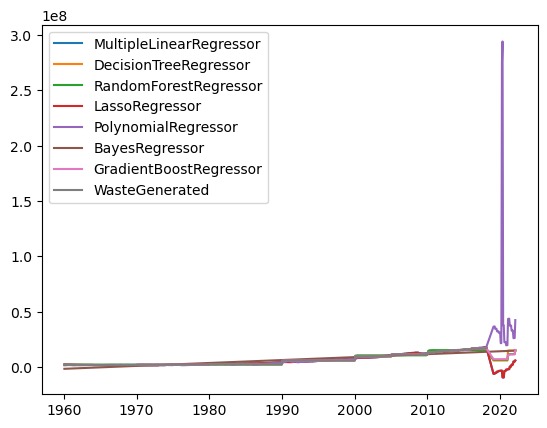

In [183]:
plt.plot('Date', 'MultipleLinearRegressor', data=normal_ff_prediction)
plt.plot('Date', 'DecisionTreeRegressor', data=normal_ff_prediction)
plt.plot('Date', 'RandomForestRegressor', data=normal_ff_prediction)
plt.plot('Date', 'LassoRegressor', data=normal_ff_prediction)
plt.plot('Date', 'PolynomialRegressor', data=normal_ff_prediction)
plt.plot('Date', 'BayesRegressor', data=normal_ff_prediction)
plt.plot('Date', 'GradientBoostRegressor', data=normal_ff_prediction)
plt.plot('Date', 'WasteGenerated', data=normal_ff_prediction)
plt.legend(loc='upper left')

In [184]:
# make a table that outlines whether a prediction is under or over the actual
condensed_table = normal_ff_prediction[['Date', 'WasteGenerated','MultipleLinearRegressor', 'DecisionTreeRegressor',
       'RandomForestRegressor', 'LassoRegressor', 'PolynomialRegressor',
       'BayesRegressor', 'GradientBoostRegressor']].copy()
condensed_table_nonan = condensed_table[condensed_table['WasteGenerated'].isna() == False]
condensed_table_nonan['MLR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['MultipleLinearRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['MultipleLinearRegressor'], 'Equal','Over'))
condensed_table_nonan['DTR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['DecisionTreeRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['DecisionTreeRegressor'], 'Equal','Over'))
condensed_table_nonan['RFR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['RandomForestRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['RandomForestRegressor'], 'Equal','Over'))
condensed_table_nonan['LR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['LassoRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['LassoRegressor'], 'Equal','Over'))
condensed_table_nonan['PR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['PolynomialRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['PolynomialRegressor'], 'Equal','Over'))
condensed_table_nonan['BR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['BayesRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['BayesRegressor'], 'Equal','Over'))
condensed_table_nonan['GBR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['GradientBoostRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['GradientBoostRegressor'], 'Equal','Over'))
condensed_under_over = condensed_table_nonan[['Date', 'WasteGenerated','MLR_UnderOver', 'DTR_UnderOver', 'RFR_UnderOver', 'LR_UnderOver',
       'PR_UnderOver', 'BR_UnderOver', 'GBR_UnderOver']].copy()
condensed_under_over

C:\Users\billy\AppData\Local\Temp\ipykernel_22948\3979994533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condensed_table_nonan['MLR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['MultipleLinearRegressor'],'Under',
C:\Users\billy\AppData\Local\Temp\ipykernel_22948\3979994533.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condensed_table_nonan['DTR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['DecisionTreeRegressor

,Date,WasteGenerated,MLR_UnderOver,DTR_UnderOver,RFR_UnderOver,LR_UnderOver,PR_UnderOver,BR_UnderOver,GBR_UnderOver
0,1960-01-31,1760000.0,Under,Equal,Under,Under,Over,Over,Under
1,1960-02-29,1760000.0,Under,Equal,Under,Under,Over,Over,Under
2,1960-03-31,1760000.0,Under,Equal,Under,Under,Over,Over,Under
3,1960-04-30,1760000.0,Under,Equal,Under,Under,Over,Over,Under
4,1960-05-31,1760000.0,Under,Equal,Under,Under,Under,Over,Under
...,...,...,...,...,...,...,...,...,...
692,2017-09-30,16890000.0,Under,Equal,Over,Under,Under,Over,Over
693,2017-10-31,16890000.0,Under,Equal,Over,Under,Under,Over,Over
694,2017-11-30,16890000.0,Under,Equal,Over,Under,Under,Over,Over
695,2017-12-31,16890000.0,Under,Equal,Over,Under,Under,Over,Over


In [185]:
MLR_Under = condensed_under_over[condensed_under_over['MLR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
RFR_Under = condensed_under_over[condensed_under_over['RFR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
LR_Under = condensed_under_over[condensed_under_over['LR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
PR_Under = condensed_under_over[condensed_under_over['PR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
BR_Under = condensed_under_over[condensed_under_over['BR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
GBR_Under = condensed_under_over[condensed_under_over['GBR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]

MLR_Over = condensed_under_over[condensed_under_over['MLR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
RFR_Over = condensed_under_over[condensed_under_over['RFR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
LR_Over = condensed_under_over[condensed_under_over['LR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
PR_Over = condensed_under_over[condensed_under_over['PR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
BR_Over = condensed_under_over[condensed_under_over['BR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
GBR_Over = condensed_under_over[condensed_under_over['GBR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]

DTR_Equal = condensed_under_over[condensed_under_over['DTR_UnderOver'] == 'Equal'].shape[0]/condensed_under_over.shape[0]

Model = ['MultipleLinear', 'DecisionTree', 'RandomForest', 'Lasso','Polynomial','Bayes','GradientBoost']
Under = [MLR_Under, np.nan, RFR_Under, LR_Under, PR_Under, BR_Under, GBR_Under]
Over = [MLR_Over, np.nan, RFR_Over, LR_Over, PR_Over, BR_Over, GBR_Over]
Equal = [np.nan, DTR_Equal, np.nan, np.nan, np.nan, np.nan, np.nan]
R2 = [MLR_R2, DTR_R2, RFR_R2, LR_R2, PR_R2, BR_R2, GBR_R2]
MAE = [MLR_MAE, DTR_MAE, RFR_MAE, LR_MAE, PR_MAE, BR_MAE, GBR_MAE]
RMSE = [MLR_RMSE, DTR_RMSE, RFR_RMSE, LR_RMSE, PR_RMSE, BR_RMSE, GBR_RMSE]
F_stat = [MLR_f_statistic, DTR_f_statistic, RFR_f_statistic, lasso_f_statistic, poly_f_statistic, bayes_f_statistic, grad_f_statistic]
p_value = [MLR_p_value, DTR_p_value, RFR_p_value, lasso_p_value, poly_p_value, bayes_p_value, grad_p_value]
data = {'Model':Model, 'Under':Under, 'Over':Over, 'Equal':Equal, 'R2':R2, 'MAE':MAE, 'RMSE':RMSE, 'ANOVA FFill F-Stat':F_stat,'ANOVA FFill P-Value':p_value}

Results = pd.DataFrame(data=data)

Results.to_csv(Directory + 'Output/results_w_anova_ffill.csv', index=False)

Results

,Model,Under,Over,Equal,R2,MAE,RMSE,ANOVA FFill F-Stat,ANOVA FFill P-Value
0,MultipleLinear,0.450502,0.549498,NaN,0.979643,5.298948e+05,6.915899e+05,4.203765e-27,1.000000
1,DecisionTree,NaN,NaN,1.0,1.000000,0.000000e+00,0.000000e+00,2.599528e-29,1.000000
2,RandomForest,0.503587,0.329986,NaN,0.980843,4.693124e+05,6.709075e+05,9.457690e-05,0.992242
3,Lasso,0.450502,0.549498,NaN,0.979643,5.298933e+05,6.915899e+05,2.479363e-26,1.000000
4,Polynomial,0.472023,0.527977,NaN,0.987820,3.720173e+05,5.349604e+05,5.544423e-22,1.000000
5,Bayes,0.497848,0.502152,NaN,0.839981,1.640355e+06,1.939012e+06,8.309914e-26,1.000000
6,GradientBoost,0.688666,0.311334,NaN,0.999957,2.692114e+04,3.195042e+04,-1.744468e-29,NaN


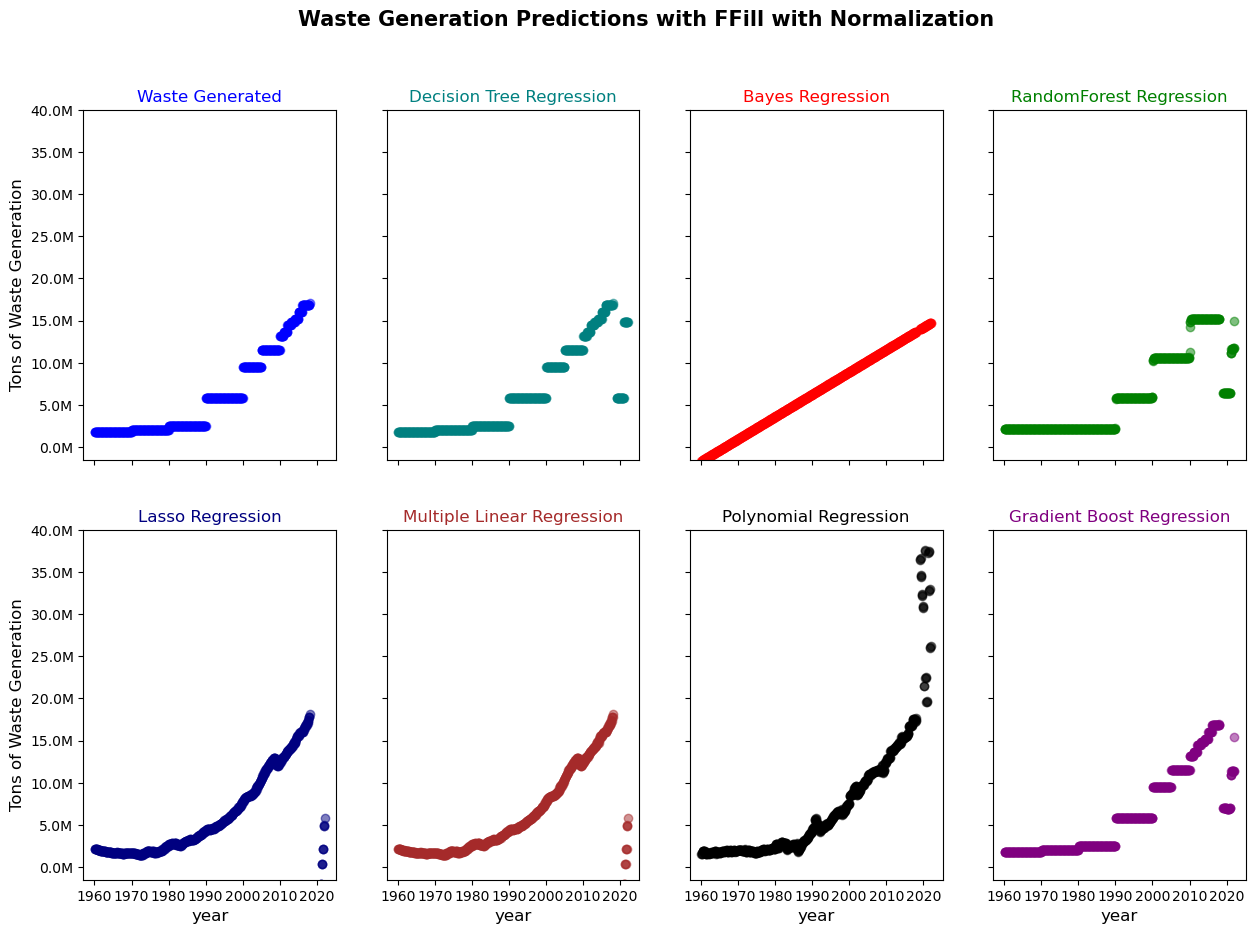

In [186]:
# Decision Tree, Bayes, and Gradient Boost had the least amount of predictions 
# under the actual values
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


formatter = FuncFormatter(millions)
# I will use these for my predictions
fig, ax = plt.subplots(2,4, figsize=(15,10), sharex=True, sharey=True)
fig.suptitle('Waste Generation Predictions with FFill with Normalization', fontsize=15, fontweight='bold')

ax[0,0].scatter('Date', 'WasteGenerated', data=normal_ff_prediction, alpha=0.5, color='blue')
ax[0,0].set_title('Waste Generated', fontsize=12, color='blue')
ax[0,0].set_ylabel('Tons of Waste Generation', fontsize=12)
ax[0,0].yaxis.set_major_formatter(formatter)

ax[0,1].scatter('Date', 'DecisionTreeRegressor', data=normal_ff_prediction, alpha=0.5, color='teal')
ax[0,1].set_title('Decision Tree Regression', fontsize=12, color='teal')
ax[0,1].yaxis.set_major_formatter(formatter)

ax[0,2].scatter('Date', 'BayesRegressor', data=normal_ff_prediction, alpha=0.5, color='red')
ax[0,2].set_title('Bayes Regression', fontsize=12, color='red')
ax[0,2].yaxis.set_major_formatter(formatter)

ax[0,3].scatter('Date', 'RandomForestRegressor', data=normal_ff_prediction, alpha=0.5, color='green')
ax[0,3].set_title('RandomForest Regression', fontsize=12, color='green')
ax[0,3].yaxis.set_major_formatter(formatter)

ax[1,0].scatter('Date', 'LassoRegressor', data=normal_ff_prediction, alpha=0.5, color='navy')
ax[1,0].set_title('Lasso Regression', fontsize=12, color='navy')
ax[1,0].set_xlabel('year', fontsize=12)
ax[1,0].set_ylabel('Tons of Waste Generation', fontsize=12)
ax[1,0].yaxis.set_major_formatter(formatter)

ax[1,1].scatter('Date', 'MultipleLinearRegressor', data=normal_ff_prediction, alpha=0.5, color='brown')
ax[1,1].set_title('Multiple Linear Regression', fontsize=12, color='brown')
ax[1,1].set_xlabel('year', fontsize=12)
ax[1,1].yaxis.set_major_formatter(formatter)

ax[1,2].scatter('Date', 'PolynomialRegressor', data=normal_ff_prediction, alpha=0.5, color='black')
ax[1,2].set_title('Polynomial Regression', fontsize=12, color='black')
ax[1,2].set_xlabel('year', fontsize=12)
ax[1,2].yaxis.set_major_formatter(formatter)

ax[1,3].scatter('Date', 'GradientBoostRegressor', data=normal_ff_prediction, alpha=0.5, color='purple')
ax[1,3].set_title('Gradient Boost Regression', fontsize=12, color='purple')
ax[1,3].set_xlabel('year', fontsize=12)
ax[1,3].yaxis.set_major_formatter(formatter)

plt.ylim(-1500000,40000000)
# plt.subplots_adjust(wspace=0, hspace=0)


plt.savefig(Directory + 'Output/original_predictions_with_ffill_w_normalization.png', dpi=90)
plt.show()

Machine Learning Fill

In [187]:
normal_filled_ml.columns

Index(['Date', 'Rec', 'GDP', 'Inflation', 'PCE', 'WasteGenerated',
       'MultipleLinearRegressor', 'DecisionTreeRegressor',
       'RandomForestRegressor', 'LassoRegressor', 'PolynomialRegressor',
       'BayesRegressor', 'GradientBoostRegressor'],
      dtype='object')

In [188]:
ff_x = normal_filled_ml.iloc[:,:5]
ff_MTR_y = normal_filled_ml.MultipleLinearRegressor
ff_DTR_y = normal_filled_ml.DecisionTreeRegressor
ff_RFR_y = normal_filled_ml.RandomForestRegressor
ff_LR_y = normal_filled_ml.LassoRegressor
ff_PR_y = normal_filled_ml.PolynomialRegressor
ff_BR_y = normal_filled_ml.BayesRegressor
ff_GBR_y = normal_filled_ml.GradientBoostRegressor

ff_x['Date']=ff_x['Date'].map(dt.datetime.toordinal)
ff_x

,Date,Rec,GDP,Inflation,PCE
0,715510,0,542.648,1.457976,29.263
1,715876,1,545.018,1.070724,29.914
2,716241,0,594.013,1.198773,31.271
3,716606,0,621.672,1.239669,32.086
4,716971,0,669.822,1.278912,34.724
5,717337,0,717.790,1.585169,36.483
6,717702,0,795.734,3.015075,39.802
7,718067,0,844.170,2.772786,41.677
8,718432,0,909.387,4.271796,45.583
9,718798,0,993.337,5.462386,48.810


In [189]:
validate_new = normal_validation[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new.dropna(inplace=True)
model = LinearRegression()
model.fit(ff_x, ff_MTR_y)
validate_new['MultipleLinearRegressor'] = model.predict(validate_new)
validate_new['Date']=validate_new['Date'].map(dt.datetime.fromordinal)

In [190]:
validate_new2 = normal_validation[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new2.dropna(inplace=True)
model = DecisionTreeRegressor()
model.fit(ff_x, ff_DTR_y)
validate_new2['DecisionTreeRegressor'] = model.predict(validate_new2)
validate_new2['Date']=validate_new2['Date'].map(dt.datetime.fromordinal)

In [191]:
validate_new3 = normal_validation[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new3.dropna(inplace=True)
model = RandomForestRegressor(max_depth=2, random_state=0)
model.fit(ff_x, ff_RFR_y)
validate_new3['RandomForestRegressor'] = model.predict(validate_new3)
validate_new3['Date']=validate_new3['Date'].map(dt.datetime.fromordinal)

In [192]:
validate_new4 = normal_validation[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new4.dropna(inplace=True)
model = linear_model.Lasso(alpha=0.1)
model.fit(ff_x, ff_LR_y)
validate_new4['LassoRegressor'] = model.predict(validate_new4)
validate_new4['Date']=validate_new4['Date'].map(dt.datetime.fromordinal)

In [193]:
validate_new5 = normal_validation[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new5.dropna(inplace=True)
#specify degree of 3 for polynomial regression model
#include bias=False means don't force y-intercept to equal zero
poly = PolynomialFeatures(degree=3, include_bias=False)

#reshape data to work properly with sklearn
poly_features = poly.fit_transform(ff_x)

#fit polynomial regression model
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, ff_PR_y)

validate_new5['PolynomialRegressor'] = model.predict(validate_new5)
validate_new5['Date']=validate_new5['Date'].map(dt.datetime.fromordinal)

In [194]:
validate_new6 = normal_validation[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new6.dropna(inplace=True)
model = linear_model.BayesianRidge()
model.fit(ff_x, ff_MTR_y)
validate_new6['BayesRegressor'] = model.predict(validate_new6)
validate_new6['Date']=validate_new6['Date'].map(dt.datetime.fromordinal)

In [195]:
validate_new7 = normal_validation[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new7.dropna(inplace=True)
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

model = ensemble.GradientBoostingRegressor(**params)
model.fit(ff_x, ff_GBR_y)
validate_new7['GradientBoostRegressor'] = model.predict(validate_new7)
validate_new7['Date']=validate_new7['Date'].map(dt.datetime.fromordinal)

In [196]:
# merge all validations
prediction = validate_new.merge(validate_new2.merge(
    validate_new3.merge(
    validate_new4.merge(
    validate_new5.merge(
    validate_new6.merge(
    validate_new7, how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']),
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE'])
normal_ml_results = pd.concat([normal_train_ml, prediction])
normal_ml_results

,Date,Rec,GDP,Inflation,PCE,WasteGenerated,MultipleLinearRegressor,DecisionTreeRegressor,RandomForestRegressor,LassoRegressor,PolynomialRegressor,BayesRegressor,GradientBoostRegressor
0,1960-01-01,0.000000,542.648000,1.457976,29.263000,1760000.0,1.760000e+06,1760000.0,3.079683e+06,1.755237e+06,1.760000e+06,1.743736e+06,1.760128e+06
1,1970-01-01,1.000000,1051.200000,5.838255,49.945000,2040000.0,2.040000e+06,2040000.0,2.189808e+06,2.038221e+06,2.040000e+06,1.799599e+06,2.040091e+06
2,1980-01-01,0.000000,2789.842000,13.549202,108.834000,2530000.0,2.530000e+06,2530000.0,2.502508e+06,2.514512e+06,2.530000e+06,3.056437e+06,2.530053e+06
3,1990-01-01,0.000000,5872.701000,5.397956,206.534000,5810000.0,5.810000e+06,5810000.0,5.930600e+06,5.880364e+06,5.810000e+06,5.625623e+06,5.809992e+06
4,2000-01-01,0.000000,10002.179000,3.376857,297.541000,9480000.0,9.480000e+06,9480000.0,9.771200e+06,9.370639e+06,9.480000e+06,9.214390e+06,9.479895e+06
5,2005-01-01,0.000000,12767.286000,3.392747,326.423000,11510000.0,1.151000e+07,11510000.0,1.062380e+07,1.157103e+07,1.151000e+07,1.169022e+07,1.150984e+07
0,2019-01-31,-0.184141,-1.092467,-0.520805,-0.050791,NaN,-3.824325e+06,5810000.0,5.035637e+06,3.328495e+06,3.328495e+06,-3.824325e+06,4.512051e+06
1,2019-02-28,-0.184141,-1.092467,-0.520805,-0.050791,NaN,-3.830436e+06,5810000.0,5.035637e+06,3.330741e+06,3.330741e+06,-3.830436e+06,4.512051e+06
2,2019-03-31,-0.184141,-1.092467,-0.520805,-0.050791,NaN,-3.837202e+06,5810000.0,5.035637e+06,3.333228e+06,3.333228e+06,-3.837202e+06,4.512051e+06
3,2019-04-30,-0.184141,-0.967283,-0.520805,-0.050791,NaN,-3.843660e+06,5810000.0,5.035637e+06,3.335732e+06,3.335732e+06,-3.843660e+06,4.512051e+06


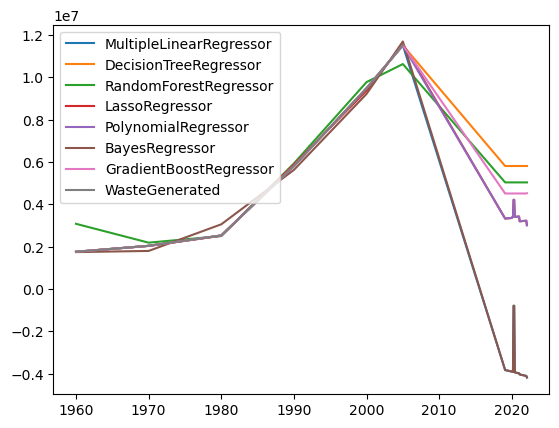

In [197]:
plt.plot('Date', 'MultipleLinearRegressor', data=normal_ml_results)
plt.plot('Date', 'DecisionTreeRegressor', data=normal_ml_results)
plt.plot('Date', 'RandomForestRegressor', data=normal_ml_results)
plt.plot('Date', 'LassoRegressor', data=normal_ml_results)
plt.plot('Date', 'PolynomialRegressor', data=normal_ml_results)
plt.plot('Date', 'BayesRegressor', data=normal_ml_results)
plt.plot('Date', 'GradientBoostRegressor', data=normal_ml_results)
plt.plot('Date', 'WasteGenerated', data=normal_ml_results)
plt.legend(loc='upper left')

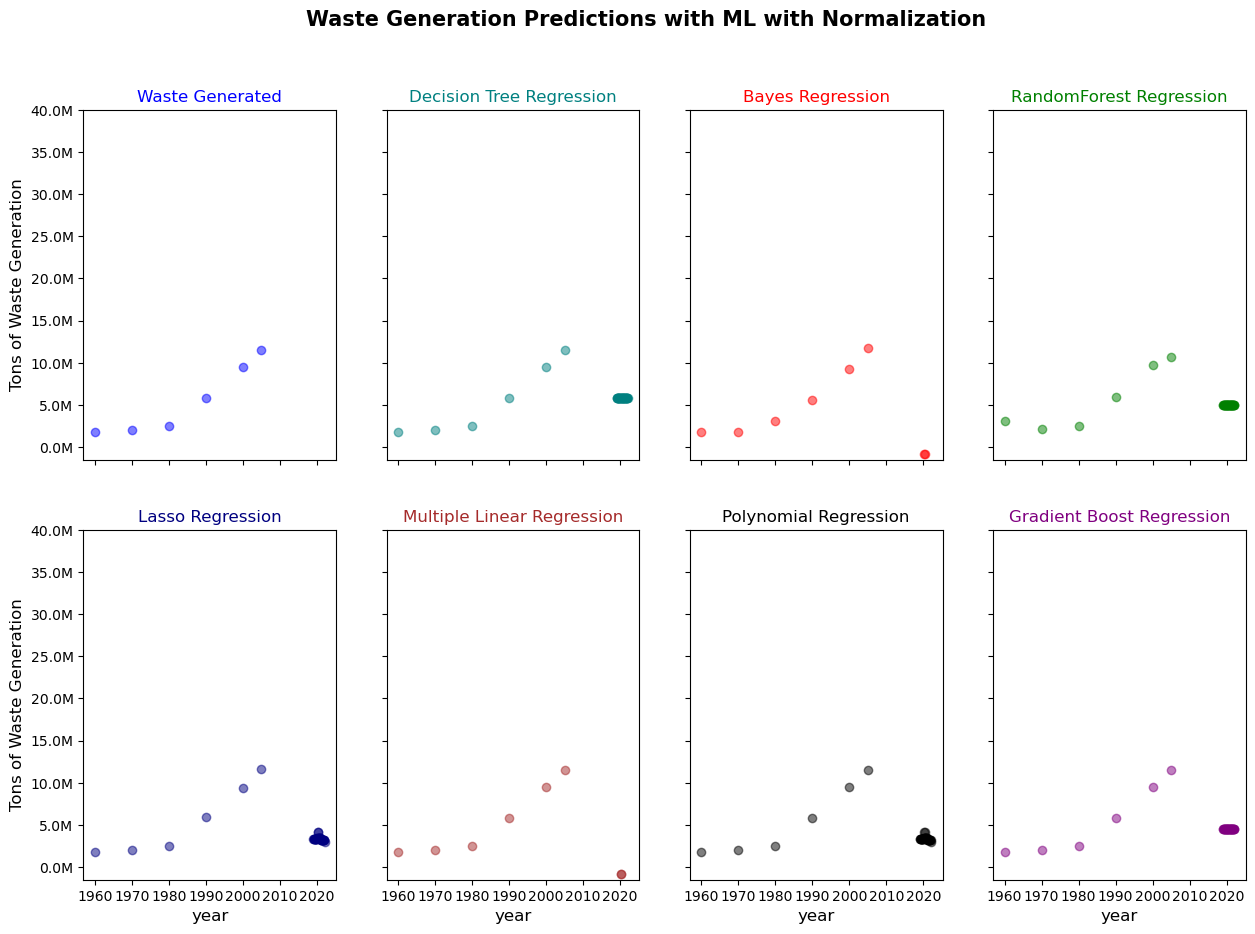

In [198]:
# Decision Tree, Bayes, and Gradient Boost had the least amount of predictions 
# under the actual values
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


formatter = FuncFormatter(millions)
# I will use these for my predictions
fig, ax = plt.subplots(2,4, figsize=(15,10), sharex=True, sharey=True)
fig.suptitle('Waste Generation Predictions with ML with Normalization', fontsize=15, fontweight='bold')

ax[0,0].scatter('Date', 'WasteGenerated', data=normal_ml_results, alpha=0.5, color='blue')
ax[0,0].set_title('Waste Generated', fontsize=12, color='blue')
ax[0,0].set_ylabel('Tons of Waste Generation', fontsize=12)
ax[0,0].yaxis.set_major_formatter(formatter)

ax[0,1].scatter('Date', 'DecisionTreeRegressor', data=normal_ml_results, alpha=0.5, color='teal')
ax[0,1].set_title('Decision Tree Regression', fontsize=12, color='teal')
ax[0,1].yaxis.set_major_formatter(formatter)

ax[0,2].scatter('Date', 'BayesRegressor', data=normal_ml_results, alpha=0.5, color='red')
ax[0,2].set_title('Bayes Regression', fontsize=12, color='red')
ax[0,2].yaxis.set_major_formatter(formatter)

ax[0,3].scatter('Date', 'RandomForestRegressor', data=normal_ml_results, alpha=0.5, color='green')
ax[0,3].set_title('RandomForest Regression', fontsize=12, color='green')
ax[0,3].yaxis.set_major_formatter(formatter)

ax[1,0].scatter('Date', 'LassoRegressor', data=normal_ml_results, alpha=0.5, color='navy')
ax[1,0].set_title('Lasso Regression', fontsize=12, color='navy')
ax[1,0].set_xlabel('year', fontsize=12)
ax[1,0].set_ylabel('Tons of Waste Generation', fontsize=12)
ax[1,0].yaxis.set_major_formatter(formatter)

ax[1,1].scatter('Date', 'MultipleLinearRegressor', data=normal_ml_results, alpha=0.5, color='brown')
ax[1,1].set_title('Multiple Linear Regression', fontsize=12, color='brown')
ax[1,1].set_xlabel('year', fontsize=12)
ax[1,1].yaxis.set_major_formatter(formatter)

ax[1,2].scatter('Date', 'PolynomialRegressor', data=normal_ml_results, alpha=0.5, color='black')
ax[1,2].set_title('Polynomial Regression', fontsize=12, color='black')
ax[1,2].set_xlabel('year', fontsize=12)
ax[1,2].yaxis.set_major_formatter(formatter)

ax[1,3].scatter('Date', 'GradientBoostRegressor', data=normal_ml_results, alpha=0.5, color='purple')
ax[1,3].set_title('Gradient Boost Regression', fontsize=12, color='purple')
ax[1,3].set_xlabel('year', fontsize=12)
ax[1,3].yaxis.set_major_formatter(formatter)

plt.ylim(-1500000,40000000)
# plt.subplots_adjust(wspace=0, hspace=0)


plt.savefig(Directory + 'Output/original_predictions_with_ml_w_normalization.png', dpi=90)
plt.show()

# Model without Normalization

In [199]:
# Not-Normalized
# train_test_ff
# filled_ml

Forward Filled

In [200]:
train_test_ff = train_test_ff[['Date', 'Rec', 'GDP', 'Inflation', 'PCE', 'WasteGenerated']].copy()
train_test_ff['Date']=train_test_ff['Date'].map(dt.datetime.toordinal)
train_test_ff.dropna(inplace=True)
ff_x = train_test_ff.iloc[:,:-1]
ff_y = train_test_ff.WasteGenerated

In [201]:
train_test_ff.head()

,Date,Rec,GDP,Inflation,PCE,WasteGenerated
0,715540,0,542.648,1.457976,29.263,1760000.0
1,715569,0,542.648,1.457976,29.263,1760000.0
2,715600,0,542.648,1.457976,29.263,1760000.0
3,715630,0,541.080,1.457976,29.263,1760000.0
4,715661,1,541.080,1.457976,29.263,1760000.0


In [202]:
model = LinearRegression()
model.fit(ff_x, ff_y)
train_test_ff['MultipleLinearRegressor'] = model.predict(ff_x)
y_true = train_test_ff['WasteGenerated']
y_pred = train_test_ff['MultipleLinearRegressor']

 # Conduct the one-way kw
MLR_kw = stats.kruskal(y_true, y_pred)
MLR_f_statistic = MLR_kw[0]
MLR_p_value = MLR_kw[1]
MLR_R2 = r2_score(y_true, y_pred)
MLR_MAE = mean_absolute_error(y_true, y_pred)
MLR_RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
MLR_R2, MLR_MAE, MLR_RMSE, MLR_f_statistic, MLR_p_value

(0.9796433344477828,
 529894.7857921441,
 691589.8674105526,
 0.7711863492078606,
 0.37985029575278983)

In [203]:
model2 = DecisionTreeRegressor()
model2.fit(ff_x, ff_y)
train_test_ff['DecisionTreeRegressor'] = model2.predict(ff_x)
yhat = train_test_ff['DecisionTreeRegressor']
# Conduct the one-way kw
DTR_kw = stats.kruskal(y_true, y_pred)
DTR_f_statistic = DTR_kw[0]
DTR_p_value = DTR_kw[1]
DTR_R2 = r2_score(y_true, yhat)
DTR_MAE = mean_absolute_error(y_true, yhat)
DTR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
DTR_R2, DTR_MAE, DTR_RMSE, DTR_f_statistic, DTR_p_value

(1.0, 0.0, 0.0, 0.7711863492078606, 0.37985029575278983)

In [204]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(ff_x, ff_y)

train_test_ff['RandomForestRegressor'] = regr.predict(ff_x)
yhat = train_test_ff['RandomForestRegressor']
RFR_kw = stats.kruskal(y_true, y_pred)
RFR_f_statistic = RFR_kw[0]
RFR_p_value = RFR_kw[1]
RFR_R2 = r2_score(y_true, yhat)
RFR_MAE = mean_absolute_error(y_true, yhat)
RFR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
RFR_R2, RFR_MAE, RFR_RMSE, RFR_f_statistic, RFR_p_value

(0.9808426828213955,
 469312.43729355023,
 670907.4984605107,
 0.7711863492078606,
 0.37985029575278983)

In [205]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(ff_x, ff_y)

train_test_ff['LassoRegressor'] = lasso.predict(ff_x)
yhat = train_test_ff['LassoRegressor']
lasso_kw = stats.kruskal(y_true, y_pred)
lasso_f_statistic = lasso_kw[0]
lasso_p_value = lasso_kw[1]
LR_R2 = r2_score(y_true, yhat)
LR_MAE = mean_absolute_error(y_true, yhat)
LR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
LR_R2, LR_MAE, LR_RMSE, lasso_f_statistic, lasso_p_value

C:\Users\billy\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e+14, tolerance: 1.638e+12
  model = cd_fast.enet_coordinate_descent(


(0.9796433344422082,
 529893.0850105914,
 691589.8675052497,
 0.7711863492078606,
 0.37985029575278983)

In [206]:
#specify degree of 3 for polynomial regression model
#include bias=False means don't force y-intercept to equal zero
poly = PolynomialFeatures(degree=3, include_bias=False)

#reshape data to work properly with sklearn
poly_features = poly.fit_transform(ff_x)

#fit polynomial regression model
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, ff_y)

train_test_ff['PolynomialRegressor'] = poly_reg_model.predict(poly_features)
yhat = train_test_ff['PolynomialRegressor']
poly_kw = stats.kruskal(y_true, y_pred)
poly_f_statistic = poly_kw[0]
poly_p_value = poly_kw[1]
PR_R2 = r2_score(y_true, yhat)
PR_MAE = mean_absolute_error(y_true, yhat)
PR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
PR_R2, PR_MAE, PR_RMSE, poly_f_statistic, poly_p_value

(0.9848623623732885,
 457206.07076719333,
 596381.7613334215,
 0.7711863492078606,
 0.37985029575278983)

In [207]:
bayes = linear_model.BayesianRidge()
bayes.fit(ff_x, ff_y)

train_test_ff['BayesRegressor'] = bayes.predict(ff_x)
yhat = train_test_ff['BayesRegressor']
bayes_kw = stats.kruskal(y_true, y_pred)
bayes_f_statistic = bayes_kw[0]
bayes_p_value = bayes_kw[1]
BR_R2 = r2_score(y_true, yhat)
BR_MAE = mean_absolute_error(y_true, yhat)
BR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
BR_R2, BR_MAE, BR_RMSE, bayes_f_statistic, bayes_p_value

(0.9795982615307299,
 527216.9965805814,
 692355.0894158477,
 0.7711863492078606,
 0.37985029575278983)

In [208]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

grad = ensemble.GradientBoostingRegressor(**params)
grad.fit(ff_x, ff_y)

train_test_ff['GradientBoostRegressor'] = grad.predict(ff_x)
yhat = train_test_ff['GradientBoostRegressor']
grad_kw = stats.kruskal(y_true, y_pred)
grad_f_statistic = grad_kw[0]
grad_p_value = grad_kw[1]
GBR_R2 = r2_score(y_true, yhat)
GBR_MAE = mean_absolute_error(y_true, yhat)
GBR_RMSE = np.sqrt(mean_squared_error(y_true, yhat))
GBR_R2, GBR_MAE, GBR_RMSE, grad_f_statistic, grad_p_value

(0.9999565527205702,
 26921.137168653586,
 31950.421695074518,
 0.7711863492078606,
 0.37985029575278983)

In [209]:
train_test_ff['Date']=train_test_ff['Date'].map(dt.datetime.fromordinal)

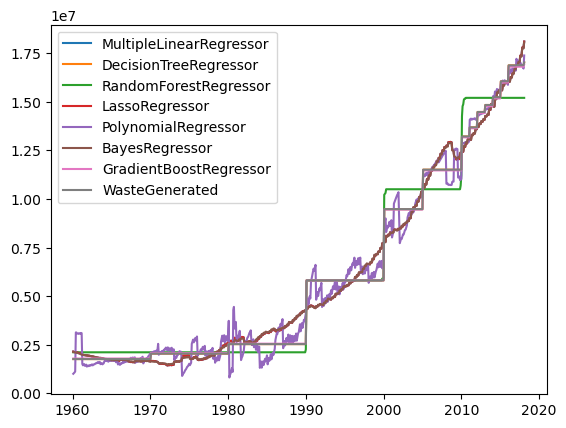

In [210]:
plt.plot('Date', 'MultipleLinearRegressor', data=train_test_ff)
plt.plot('Date', 'DecisionTreeRegressor', data=train_test_ff)
plt.plot('Date', 'RandomForestRegressor', data=train_test_ff)
plt.plot('Date', 'LassoRegressor', data=train_test_ff)
plt.plot('Date', 'PolynomialRegressor', data=train_test_ff)
plt.plot('Date', 'BayesRegressor', data=train_test_ff)
plt.plot('Date', 'GradientBoostRegressor', data=train_test_ff)
plt.plot('Date', 'WasteGenerated', data=train_test_ff)
plt.legend(loc='upper left')

In [211]:
validate_ff['Date'] = validate_ff['Date'].map(dt.datetime.toordinal)
validate_new = validate_ff[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new.dropna(inplace=True)
x_new = validate_new
validate_new['DecisionTreeRegressor'] = model2.predict(x_new)
validate_new['Date'] = validate_new['Date'].map(dt.datetime.fromordinal)


In [212]:
validate_new2 = validate_ff[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new2.dropna(inplace=True)
x_new2 = validate_new2
validate_new2['MultipleLinearRegressor'] = model.predict(x_new2)
validate_new2['Date'] = validate_new2['Date'].map(dt.datetime.fromordinal)


In [213]:
validate_new3 = validate_ff[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new3.dropna(inplace=True)
x_new3 = validate_new3

validate_new3['RandomForestRegressor'] = regr.predict(x_new3)
validate_new3['Date'] = validate_new3['Date'].map(dt.datetime.fromordinal)


In [214]:
validate_new4 = validate_ff[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new4.dropna(inplace=True)
x_new4 = validate_new4

validate_new4['LassoRegressor'] = lasso.predict(x_new4)
validate_new4['Date'] = validate_new4['Date'].map(dt.datetime.fromordinal)


In [215]:
validate_new5 = validate_ff[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new5.dropna(inplace=True)
x_new5 = validate_new5

validate_new5['BayesRegressor'] = bayes.predict(x_new5)
validate_new5['Date'] = validate_new5['Date'].map(dt.datetime.fromordinal)


In [216]:
validate_new6 = validate_ff[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new6.dropna(inplace=True)
x_new6 = validate_new6
poly_features = poly.fit_transform(x_new6)

validate_new6['PolynomialRegressor'] = poly_reg_model.predict(poly_features)
validate_new6['Date'] = validate_new6['Date'].map(dt.datetime.fromordinal)


In [217]:
validate_new7 = validate_ff[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new7.dropna(inplace=True)
x_new7 = validate_new7

validate_new7['GradientBoostRegressor'] = grad.predict(x_new7)
validate_new7['Date'] = validate_new7['Date'].map(dt.datetime.fromordinal)


In [218]:
ff_prediction = validate_new.merge(validate_new2.merge(
    validate_new3.merge(
    validate_new4.merge(
    validate_new5.merge(
    validate_new6.merge(
    validate_new7, how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']),
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE'])
ff_prediction = pd.concat([train_test_ff, ff_prediction])
ff_prediction

,Date,Rec,GDP,Inflation,PCE,WasteGenerated,MultipleLinearRegressor,DecisionTreeRegressor,RandomForestRegressor,LassoRegressor,PolynomialRegressor,BayesRegressor,GradientBoostRegressor
0,1960-01-31,0,542.648,1.457976,29.263,1760000.0,2.146040e+06,1760000.0,2.108940e+06,2.146018e+06,1.002663e+06,2.130124e+06,1.787923e+06
1,1960-02-29,0,542.648,1.457976,29.263,1760000.0,2.136068e+06,1760000.0,2.108940e+06,2.136046e+06,1.036649e+06,2.120979e+06,1.787923e+06
2,1960-03-31,0,542.648,1.457976,29.263,1760000.0,2.125407e+06,1760000.0,2.108940e+06,2.125387e+06,1.072695e+06,2.111204e+06,1.787923e+06
3,1960-04-30,0,541.080,1.457976,29.263,1760000.0,2.113051e+06,1760000.0,2.108940e+06,2.113030e+06,1.121043e+06,2.099712e+06,1.787923e+06
4,1960-05-31,1,541.080,1.457976,29.263,1760000.0,2.124333e+06,1760000.0,2.108940e+06,2.124311e+06,3.134380e+06,2.092874e+06,1.787923e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,2021-09-30,0,23828.973,4.697859,484.482,NaN,2.196376e+07,17030000.0,1.520779e+07,2.196373e+07,1.309483e+07,2.182729e+07,1.692729e+07
33,2021-10-31,0,24654.603,4.697859,484.482,NaN,2.302753e+07,17030000.0,1.520779e+07,2.302750e+07,8.703996e+06,2.288801e+07,1.692729e+07
34,2021-11-30,0,24654.603,4.697859,484.482,NaN,2.301721e+07,17030000.0,1.520779e+07,2.301719e+07,8.532511e+06,2.287855e+07,1.692729e+07
35,2021-12-31,0,24654.603,4.697859,484.482,NaN,2.300655e+07,17030000.0,1.520779e+07,2.300653e+07,8.355075e+06,2.286878e+07,1.692729e+07


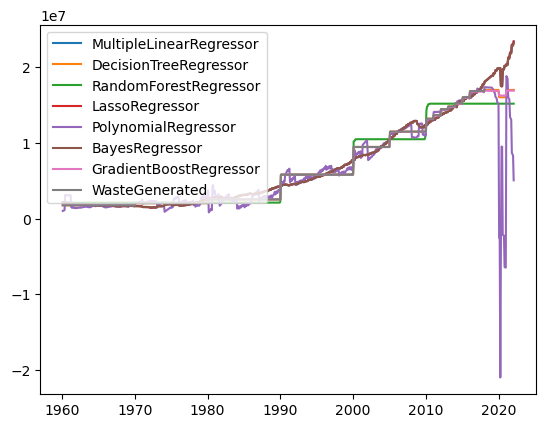

In [219]:
plt.plot('Date', 'MultipleLinearRegressor', data=ff_prediction)
plt.plot('Date', 'DecisionTreeRegressor', data=ff_prediction)
plt.plot('Date', 'RandomForestRegressor', data=ff_prediction)
plt.plot('Date', 'LassoRegressor', data=ff_prediction)
plt.plot('Date', 'PolynomialRegressor', data=ff_prediction)
plt.plot('Date', 'BayesRegressor', data=ff_prediction)
plt.plot('Date', 'GradientBoostRegressor', data=ff_prediction)
plt.plot('Date', 'WasteGenerated', data=ff_prediction)
plt.legend(loc='upper left')

In [220]:
# make a table that outlines whether a prediction is under or over the actual
condensed_table = ff_prediction[['Date', 'WasteGenerated','MultipleLinearRegressor', 'DecisionTreeRegressor',
       'RandomForestRegressor', 'LassoRegressor', 'PolynomialRegressor',
       'BayesRegressor', 'GradientBoostRegressor']].copy()
condensed_table_nonan = condensed_table[condensed_table['WasteGenerated'].isna() == False]
condensed_table_nonan['MLR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['MultipleLinearRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['MultipleLinearRegressor'], 'Equal','Over'))
condensed_table_nonan['DTR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['DecisionTreeRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['DecisionTreeRegressor'], 'Equal','Over'))
condensed_table_nonan['RFR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['RandomForestRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['RandomForestRegressor'], 'Equal','Over'))
condensed_table_nonan['LR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['LassoRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['LassoRegressor'], 'Equal','Over'))
condensed_table_nonan['PR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['PolynomialRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['PolynomialRegressor'], 'Equal','Over'))
condensed_table_nonan['BR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['BayesRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['BayesRegressor'], 'Equal','Over'))
condensed_table_nonan['GBR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['GradientBoostRegressor'],'Under',
                                                  np.where(condensed_table_nonan['WasteGenerated'] == condensed_table_nonan['GradientBoostRegressor'], 'Equal','Over'))
condensed_under_over = condensed_table_nonan[['Date', 'WasteGenerated','MLR_UnderOver', 'DTR_UnderOver', 'RFR_UnderOver', 'LR_UnderOver',
       'PR_UnderOver', 'BR_UnderOver', 'GBR_UnderOver']].copy()
condensed_under_over

C:\Users\billy\AppData\Local\Temp\ipykernel_22948\2217599563.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condensed_table_nonan['MLR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['MultipleLinearRegressor'],'Under',
C:\Users\billy\AppData\Local\Temp\ipykernel_22948\2217599563.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condensed_table_nonan['DTR_UnderOver'] = np.where(condensed_table_nonan['WasteGenerated'] < condensed_table_nonan['DecisionTreeRegressor

,Date,WasteGenerated,MLR_UnderOver,DTR_UnderOver,RFR_UnderOver,LR_UnderOver,PR_UnderOver,BR_UnderOver,GBR_UnderOver
0,1960-01-31,1760000.0,Under,Equal,Under,Under,Over,Under,Under
1,1960-02-29,1760000.0,Under,Equal,Under,Under,Over,Under,Under
2,1960-03-31,1760000.0,Under,Equal,Under,Under,Over,Under,Under
3,1960-04-30,1760000.0,Under,Equal,Under,Under,Over,Under,Under
4,1960-05-31,1760000.0,Under,Equal,Under,Under,Under,Under,Under
...,...,...,...,...,...,...,...,...,...
692,2017-09-30,16890000.0,Under,Equal,Over,Under,Over,Under,Over
693,2017-10-31,16890000.0,Under,Equal,Over,Under,Over,Under,Over
694,2017-11-30,16890000.0,Under,Equal,Over,Under,Over,Under,Over
695,2017-12-31,16890000.0,Under,Equal,Over,Under,Over,Under,Over


In [221]:
MLR_Under = condensed_under_over[condensed_under_over['MLR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
RFR_Under = condensed_under_over[condensed_under_over['RFR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
LR_Under = condensed_under_over[condensed_under_over['LR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
PR_Under = condensed_under_over[condensed_under_over['PR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
BR_Under = condensed_under_over[condensed_under_over['BR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]
GBR_Under = condensed_under_over[condensed_under_over['GBR_UnderOver'] == 'Under'].shape[0]/condensed_under_over.shape[0]

MLR_Over = condensed_under_over[condensed_under_over['MLR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
RFR_Over = condensed_under_over[condensed_under_over['RFR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
LR_Over = condensed_under_over[condensed_under_over['LR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
PR_Over = condensed_under_over[condensed_under_over['PR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
BR_Over = condensed_under_over[condensed_under_over['BR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]
GBR_Over = condensed_under_over[condensed_under_over['GBR_UnderOver'] == 'Over'].shape[0]/condensed_under_over.shape[0]

DTR_Equal = condensed_under_over[condensed_under_over['DTR_UnderOver'] == 'Equal'].shape[0]/condensed_under_over.shape[0]

Model = ['MultipleLinear', 'DecisionTree', 'RandomForest', 'Lasso','Polynomial','Bayes','GradientBoost']
Under = [MLR_Under, np.nan, RFR_Under, LR_Under, PR_Under, BR_Under, GBR_Under]
Over = [MLR_Over, np.nan, RFR_Over, LR_Over, PR_Over, BR_Over, GBR_Over]
Equal = [np.nan, DTR_Equal, np.nan, np.nan, np.nan, np.nan, np.nan]
R2 = [MLR_R2, DTR_R2, RFR_R2, LR_R2, PR_R2, BR_R2, GBR_R2]
MAE = [MLR_MAE, DTR_MAE, RFR_MAE, LR_MAE, PR_MAE, BR_MAE, GBR_MAE]
RMSE = [MLR_RMSE, DTR_RMSE, RFR_RMSE, LR_RMSE, PR_RMSE, BR_RMSE, GBR_RMSE]
F_stat = [MLR_f_statistic, DTR_f_statistic, RFR_f_statistic, lasso_f_statistic, poly_f_statistic, bayes_f_statistic, grad_f_statistic]
p_value = [MLR_p_value, DTR_p_value, RFR_p_value, lasso_p_value, poly_p_value, bayes_p_value, grad_p_value]
data = {'Model':Model, 'Under':Under, 'Over':Over, 'Equal':Equal, 'R2':R2, 'MAE':MAE, 'RMSE':RMSE, 'KW FFill F-Stat':F_stat,'KW FFill P-Value':p_value}

Results = pd.DataFrame(data=data)

Results.to_csv(Directory + 'Output/results_w_kw_ffill.csv', index=False)

Results

,Model,Under,Over,Equal,R2,MAE,RMSE,KW FFill F-Stat,KW FFill P-Value
0,MultipleLinear,0.450502,0.549498,NaN,0.979643,529894.785792,691589.867411,0.771186,0.37985
1,DecisionTree,NaN,NaN,1.0,1.000000,0.000000,0.000000,0.771186,0.37985
2,RandomForest,0.503587,0.329986,NaN,0.980843,469312.437294,670907.498461,0.771186,0.37985
3,Lasso,0.450502,0.549498,NaN,0.979643,529893.085011,691589.867505,0.771186,0.37985
4,Polynomial,0.470588,0.529412,NaN,0.984862,457206.070767,596381.761333,0.771186,0.37985
5,Bayes,0.453372,0.546628,NaN,0.979598,527216.996581,692355.089416,0.771186,0.37985
6,GradientBoost,0.688666,0.311334,NaN,0.999957,26921.137169,31950.421695,0.771186,0.37985


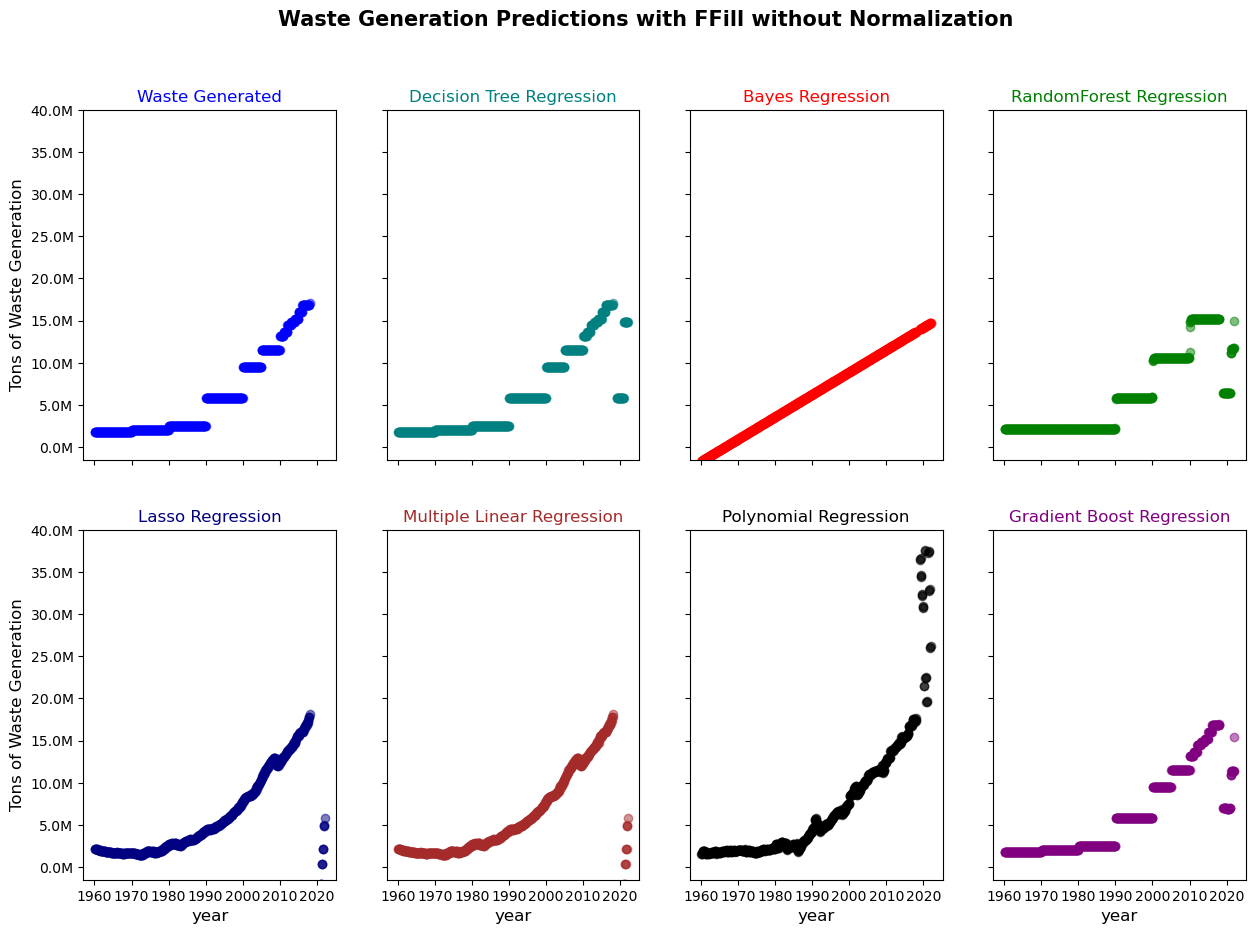

In [222]:
# Decision Tree, Bayes, and Gradient Boost had the least amount of predictions 
# under the actual values
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


formatter = FuncFormatter(millions)
# I will use these for my predictions
fig, ax = plt.subplots(2,4, figsize=(15,10), sharex=True, sharey=True)
fig.suptitle('Waste Generation Predictions with FFill without Normalization', fontsize=15, fontweight='bold')

ax[0,0].scatter('Date', 'WasteGenerated', data=normal_ff_prediction, alpha=0.5, color='blue')
ax[0,0].set_title('Waste Generated', fontsize=12, color='blue')
ax[0,0].set_ylabel('Tons of Waste Generation', fontsize=12)
ax[0,0].yaxis.set_major_formatter(formatter)

ax[0,1].scatter('Date', 'DecisionTreeRegressor', data=normal_ff_prediction, alpha=0.5, color='teal')
ax[0,1].set_title('Decision Tree Regression', fontsize=12, color='teal')
ax[0,1].yaxis.set_major_formatter(formatter)

ax[0,2].scatter('Date', 'BayesRegressor', data=normal_ff_prediction, alpha=0.5, color='red')
ax[0,2].set_title('Bayes Regression', fontsize=12, color='red')
ax[0,2].yaxis.set_major_formatter(formatter)

ax[0,3].scatter('Date', 'RandomForestRegressor', data=normal_ff_prediction, alpha=0.5, color='green')
ax[0,3].set_title('RandomForest Regression', fontsize=12, color='green')
ax[0,3].yaxis.set_major_formatter(formatter)

ax[1,0].scatter('Date', 'LassoRegressor', data=normal_ff_prediction, alpha=0.5, color='navy')
ax[1,0].set_title('Lasso Regression', fontsize=12, color='navy')
ax[1,0].set_xlabel('year', fontsize=12)
ax[1,0].set_ylabel('Tons of Waste Generation', fontsize=12)
ax[1,0].yaxis.set_major_formatter(formatter)

ax[1,1].scatter('Date', 'MultipleLinearRegressor', data=normal_ff_prediction, alpha=0.5, color='brown')
ax[1,1].set_title('Multiple Linear Regression', fontsize=12, color='brown')
ax[1,1].set_xlabel('year', fontsize=12)
ax[1,1].yaxis.set_major_formatter(formatter)

ax[1,2].scatter('Date', 'PolynomialRegressor', data=normal_ff_prediction, alpha=0.5, color='black')
ax[1,2].set_title('Polynomial Regression', fontsize=12, color='black')
ax[1,2].set_xlabel('year', fontsize=12)
ax[1,2].yaxis.set_major_formatter(formatter)

ax[1,3].scatter('Date', 'GradientBoostRegressor', data=normal_ff_prediction, alpha=0.5, color='purple')
ax[1,3].set_title('Gradient Boost Regression', fontsize=12, color='purple')
ax[1,3].set_xlabel('year', fontsize=12)
ax[1,3].yaxis.set_major_formatter(formatter)

plt.ylim(-1500000,40000000)
# plt.subplots_adjust(wspace=0, hspace=0)


plt.savefig(Directory + 'Output/original_predictions_with_ffill_wo_normalization.png', dpi=90)
plt.show()

Machine Learning Fill

In [109]:
train_ml.columns

Index(['Date', 'Rec', 'GDP', 'Inflation', 'PCE', 'WasteGenerated',
       'MultipleLinearRegressor', 'DecisionTreeRegressor',
       'RandomForestRegressor', 'LassoRegressor', 'PolynomialRegressor',
       'BayesRegressor', 'GradientBoostRegressor'],
      dtype='object')

In [110]:
ff_x = train_ml.iloc[:,:5]
ff_MTR_y = train_ml.MultipleLinearRegressor
ff_DTR_y = train_ml.DecisionTreeRegressor
ff_RFR_y = train_ml.RandomForestRegressor
ff_LR_y = train_ml.LassoRegressor
ff_PR_y = train_ml.PolynomialRegressor
ff_BR_y = train_ml.BayesRegressor
ff_GBR_y = train_ml.GradientBoostRegressor

ff_x['Date']=ff_x['Date'].map(dt.datetime.toordinal)
ff_x

,Date,Rec,GDP,Inflation,PCE
0,715510,0,542.648,1.457976,29.263
1,719163,1,1051.200,5.838255,49.945
2,722815,0,2789.842,13.549202,108.834
3,726468,0,5872.701,5.397956,206.534
4,730120,0,10002.179,3.376857,297.541
5,731947,0,12767.286,3.392747,326.423


In [111]:
validate_ml['Date'] = validate_ml['Date'].map(dt.datetime.toordinal)
validate_new = validate_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new.dropna(inplace=True)
model = LinearRegression()
model.fit(ff_x, ff_MTR_y)
validate_new['MultipleLinearRegressor'] = model.predict(validate_new)


In [112]:
validate_new2 = validate_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new2.dropna(inplace=True)
model = DecisionTreeRegressor()
model.fit(ff_x, ff_DTR_y)
validate_new2['DecisionTreeRegressor'] = model.predict(validate_new2)

In [113]:
validate_new3 = validate_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new3.dropna(inplace=True)
model = RandomForestRegressor(max_depth=2, random_state=0)
model.fit(ff_x, ff_RFR_y)
validate_new3['RandomForestRegressor'] = model.predict(validate_new3)

In [114]:
validate_new4 = validate_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new4.dropna(inplace=True)
model = linear_model.Lasso(alpha=0.1)
model.fit(ff_x, ff_LR_y)
validate_new4['LassoRegressor'] = model.predict(validate_new4)

In [115]:
validate_new5 = validate_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new5.dropna(inplace=True)
#specify degree of 3 for polynomial regression model
#include bias=False means don't force y-intercept to equal zero
poly = PolynomialFeatures(degree=3, include_bias=False)

#reshape data to work properly with sklearn
poly_features = poly.fit_transform(ff_x)

#fit polynomial regression model
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, ff_PR_y)

validate_new5['PolynomialRegressor'] = model.predict(validate_new5)

In [116]:
validate_new6 = validate_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new6.dropna(inplace=True)
model = linear_model.BayesianRidge()
model.fit(ff_x, ff_MTR_y)
validate_new6['BayesRegressor'] = model.predict(validate_new6)

In [117]:
validate_new7 = validate_ml[['Date', 'Rec', 'GDP', 'Inflation', 'PCE']].copy()
validate_new7.dropna(inplace=True)
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

model = ensemble.GradientBoostingRegressor(**params)
model.fit(ff_x, ff_GBR_y)
validate_new7['GradientBoostRegressor'] = model.predict(validate_new7)

In [118]:
# merge all validations
prediction = validate_new.merge(validate_new2.merge(
    validate_new3.merge(
    validate_new4.merge(
    validate_new5.merge(
    validate_new6.merge(
    validate_new7, how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']),
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE']), 
        how='left', on=['Date', 'Rec', 'GDP', 'Inflation', 'PCE'])
ml_results = pd.concat([normal_train_ml, prediction])
ml_results

,Date,Rec,GDP,Inflation,PCE,WasteGenerated,MultipleLinearRegressor,DecisionTreeRegressor,RandomForestRegressor,LassoRegressor,PolynomialRegressor,BayesRegressor,GradientBoostRegressor
0,1960-01-01 00:00:00,0,542.648,1.457976,29.263,1760000.0,1.760000e+06,1760000.0,3.079683e+06,1.755237e+06,1.760000e+06,1.743736e+06,1.760128e+06
1,1970-01-01 00:00:00,1,1051.200,5.838255,49.945,2040000.0,2.040000e+06,2040000.0,2.189808e+06,2.038221e+06,2.040000e+06,1.799599e+06,2.040091e+06
2,1980-01-01 00:00:00,0,2789.842,13.549202,108.834,2530000.0,2.530000e+06,2530000.0,2.502508e+06,2.514512e+06,2.530000e+06,3.056437e+06,2.530053e+06
3,1990-01-01 00:00:00,0,5872.701,5.397956,206.534,5810000.0,5.810000e+06,5810000.0,5.930600e+06,5.880364e+06,5.810000e+06,5.625623e+06,5.809992e+06
4,2000-01-01 00:00:00,0,10002.179,3.376857,297.541,9480000.0,9.480000e+06,9480000.0,9.771200e+06,9.370639e+06,9.480000e+06,9.214390e+06,9.479895e+06
5,2005-01-01 00:00:00,0,12767.286,3.392747,326.423,11510000.0,1.151000e+07,11510000.0,1.062380e+07,1.157103e+07,1.151000e+07,1.169022e+07,1.150984e+07
0,737060,0,21104.133,1.812210,432.901,NaN,1.808993e+07,11510000.0,9.996866e+06,1.845912e+07,1.845912e+07,1.920372e+07,1.139565e+07
1,737425,0,21706.513,1.233584,381.164,NaN,1.764683e+07,11510000.0,9.996866e+06,1.979614e+07,1.979614e+07,1.974379e+07,1.139565e+07
2,737791,0,22600.185,4.697859,484.482,NaN,1.969426e+07,11510000.0,9.233593e+06,1.872245e+07,1.872245e+07,2.057632e+07,1.139565e+07
3,738156,0,25029.116,8.002800,518.323,NaN,2.174686e+07,11510000.0,9.055153e+06,1.980132e+07,1.980132e+07,2.290118e+07,1.139565e+07


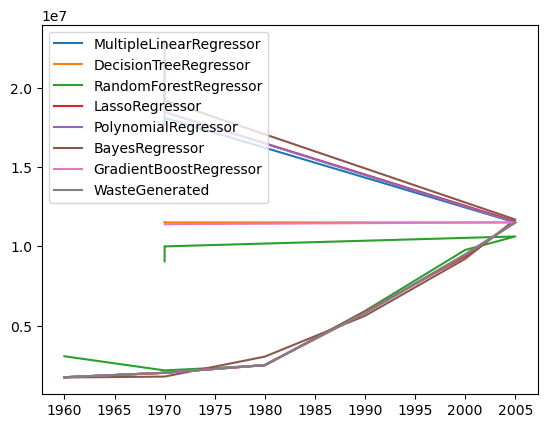

In [119]:
plt.plot('Date', 'MultipleLinearRegressor', data=ml_results)
plt.plot('Date', 'DecisionTreeRegressor', data=ml_results)
plt.plot('Date', 'RandomForestRegressor', data=ml_results)
plt.plot('Date', 'LassoRegressor', data=ml_results)
plt.plot('Date', 'PolynomialRegressor', data=ml_results)
plt.plot('Date', 'BayesRegressor', data=ml_results)
plt.plot('Date', 'GradientBoostRegressor', data=ml_results)
plt.plot('Date', 'WasteGenerated', data=ml_results)
plt.legend(loc='upper left')

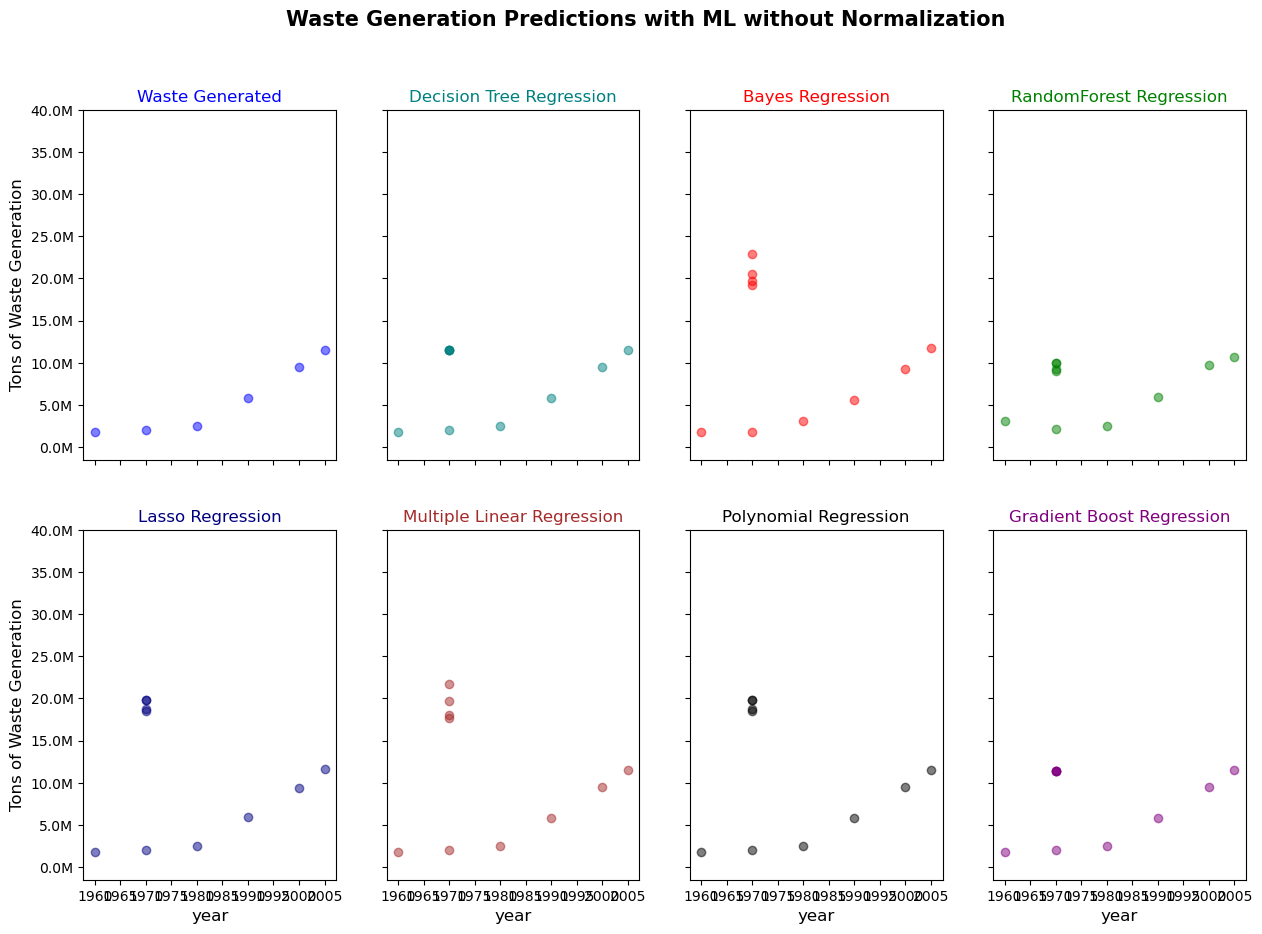

In [125]:
# Decision Tree, Bayes, and Gradient Boost had the least amount of predictions 
# under the actual values
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


formatter = FuncFormatter(millions)
# I will use these for my predictions
fig, ax = plt.subplots(2,4, figsize=(15,10), sharex=True, sharey=True)
fig.suptitle('Waste Generation Predictions with ML without Normalization', fontsize=15, fontweight='bold')

ax[0,0].scatter('Date', 'WasteGenerated', data=ml_results, alpha=0.5, color='blue')
ax[0,0].set_title('Waste Generated', fontsize=12, color='blue')
ax[0,0].set_ylabel('Tons of Waste Generation', fontsize=12)
ax[0,0].yaxis.set_major_formatter(formatter)

ax[0,1].scatter('Date', 'DecisionTreeRegressor', data=ml_results, alpha=0.5, color='teal')
ax[0,1].set_title('Decision Tree Regression', fontsize=12, color='teal')
ax[0,1].yaxis.set_major_formatter(formatter)

ax[0,2].scatter('Date', 'BayesRegressor', data=ml_results, alpha=0.5, color='red')
ax[0,2].set_title('Bayes Regression', fontsize=12, color='red')
ax[0,2].yaxis.set_major_formatter(formatter)

ax[0,3].scatter('Date', 'RandomForestRegressor', data=ml_results, alpha=0.5, color='green')
ax[0,3].set_title('RandomForest Regression', fontsize=12, color='green')
ax[0,3].yaxis.set_major_formatter(formatter)

ax[1,0].scatter('Date', 'LassoRegressor', data=ml_results, alpha=0.5, color='navy')
ax[1,0].set_title('Lasso Regression', fontsize=12, color='navy')
ax[1,0].set_xlabel('year', fontsize=12)
ax[1,0].set_ylabel('Tons of Waste Generation', fontsize=12)
ax[1,0].yaxis.set_major_formatter(formatter)

ax[1,1].scatter('Date', 'MultipleLinearRegressor', data=ml_results, alpha=0.5, color='brown')
ax[1,1].set_title('Multiple Linear Regression', fontsize=12, color='brown')
ax[1,1].set_xlabel('year', fontsize=12)
ax[1,1].yaxis.set_major_formatter(formatter)

ax[1,2].scatter('Date', 'PolynomialRegressor', data=ml_results, alpha=0.5, color='black')
ax[1,2].set_title('Polynomial Regression', fontsize=12, color='black')
ax[1,2].set_xlabel('year', fontsize=12)
ax[1,2].yaxis.set_major_formatter(formatter)

ax[1,3].scatter('Date', 'GradientBoostRegressor', data=ml_results, alpha=0.5, color='purple')
ax[1,3].set_title('Gradient Boost Regression', fontsize=12, color='purple')
ax[1,3].set_xlabel('year', fontsize=12)
ax[1,3].yaxis.set_major_formatter(formatter)

plt.ylim(-1500000,40000000)
# plt.subplots_adjust(wspace=0, hspace=0)


plt.savefig(Directory + 'Output/original_predictions_with_ml_wo_normalization.png', dpi=90)
plt.show()